# Proyecto SPRINT 8 - ANÁLISIS DE NEGOCIO


### Tarea:

Estoy realizando una pasantía en el departamento analítico de Yandex.Afisha. Mi primera tarea es ayudar a optimizar los costos de marketing.

### Tengo:

- Registros del servidor con datos sobre las visitas a Yandex.Afisha desde junio de 2017 hasta mayo de 2018.
- Archivo con todos los pedidos del período.
- Estadísticas de gastos de marketing.

### Mi plan es averiguar:

- Cómo utilizan el producto las personas.
- Cuánto tiempo pasa desde que el cliente visita el sitio hasta la primera compra.
- Cuánto dinero trae cada cliente.
- La eficacia de las fuentes de adquisición de clientes.

> Al final, sacaré conclusiones y prepararé propuestas para el departamento de marketing.

## Paso 1 : preparando data para analizarla


In [155]:
#importando bibliotecas

import pandas as pd
from scipy import stats as st
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

- Analisis preliminar. estructura de datos

In [156]:
visits = pd.read_csv("datasets/visits_log_us.csv")
orders = pd.read_csv("datasets/orders_log_us.csv")
costs = pd.read_csv("datasets/costs_us.csv")

In [157]:
print("Visits: \n")
print(visits.info())

Visits: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


In [158]:
visits["Device"].value_counts()

Device
desktop    262567
touch       96833
Name: count, dtype: int64

In [159]:
print("Orders: \n")
print(orders.info())

Orders: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


In [160]:
print("Сosts: \n")
print(costs.info())

Сosts: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


1. **2 Procesamiento de Data**

In [161]:
print("Duplicates found - ", visits.duplicated().sum(), " records")
visits[:5]

Duplicates found -  0  records


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [162]:
print("Duplicates found - ", orders.duplicated().sum(), " records")
orders[:5]

Duplicates found -  0  records


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [163]:
print("Duplicates found - ", costs.duplicated().sum(), " records")
costs[:5]

Duplicates found -  0  records


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Conclusión:

- No se encontraron datos faltantes.
- No se encontraron duplicados.
- No es necesario convertir el tipo de datos.
- Para mayor comodidad, necesitamos renombrar las columnas. Eliminaremos los espacios y convertiremos todas las letras a minúsculas.

In [164]:
visits = visits.rename(
    columns={"End Ts": "End_Ts", "Source Id": "Source_Id", "Start Ts": "Start_Ts"}
)
orders = orders.rename(columns={"Buy Ts": "Buy_Ts"})
visits = visits.rename(str.lower, axis="columns")
orders = orders.rename(str.lower, axis="columns")

## Paso 2

### 1. **Visitas**

- **¿Cuántas personas utilizan nuestro servicio cada día, semana y mes?**

In [165]:
# Asegúrate de que la columna 'start_ts' sea de tipo datetime
visits["start_ts"] = pd.to_datetime(visits["start_ts"])

# Extraer el día, la semana, el mes y el año
visits["day"] = visits["start_ts"].dt.day
visits["week"] = visits["start_ts"].dt.isocalendar().week
visits["month"] = visits["start_ts"].dt.month
visits["year"] = visits["start_ts"].dt.year

# Calcular DAU, WAU y MAU
dau = visits.groupby(["day", "month", "year"]).agg({"uid": "nunique"}).mean()
wau = visits.groupby(["week", "year"]).agg({"uid": "nunique"}).mean()
mau = visits.groupby(["month", "year"]).agg({"uid": "nunique"}).mean()

# Mostrar resultados
print("{:} personas usan la aplicación todos los días.".format(int(dau)))
print("{:} personas usan la aplicación todas las semanas.".format(int(wau)))
print("{:} personas usan la aplicación todos los meses.".format(int(mau)))

907 personas usan la aplicación todos los días.
5716 personas usan la aplicación todas las semanas.
23228 personas usan la aplicación todos los meses.


C:\Users\User\AppData\Local\Temp\ipykernel_24340\1306282932.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print("{:} personas usan la aplicación todos los días.".format(int(dau)))
C:\Users\User\AppData\Local\Temp\ipykernel_24340\1306282932.py:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print("{:} personas usan la aplicación todas las semanas.".format(int(wau)))
C:\Users\User\AppData\Local\Temp\ipykernel_24340\1306282932.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print("{:} personas usan la aplicación todos los meses.".format(int(mau)))


- Graficando:

In [166]:
# Preparemos los datos para construir el gráfico "Número de usuarios por día"
# DAU
dau_graph = visits.groupby(["year", "month", "day"]).agg({"uid": "nunique"})
dau_graph = dau_graph.reset_index()

dau_graph["day"] = dau_graph["day"].astype("string")
dau_graph["month"] = dau_graph["month"].astype("string")
dau_graph["year"] = dau_graph["year"].astype("string")

dau_graph["xticks"] = dau_graph["month"] + "." + dau_graph["year"]

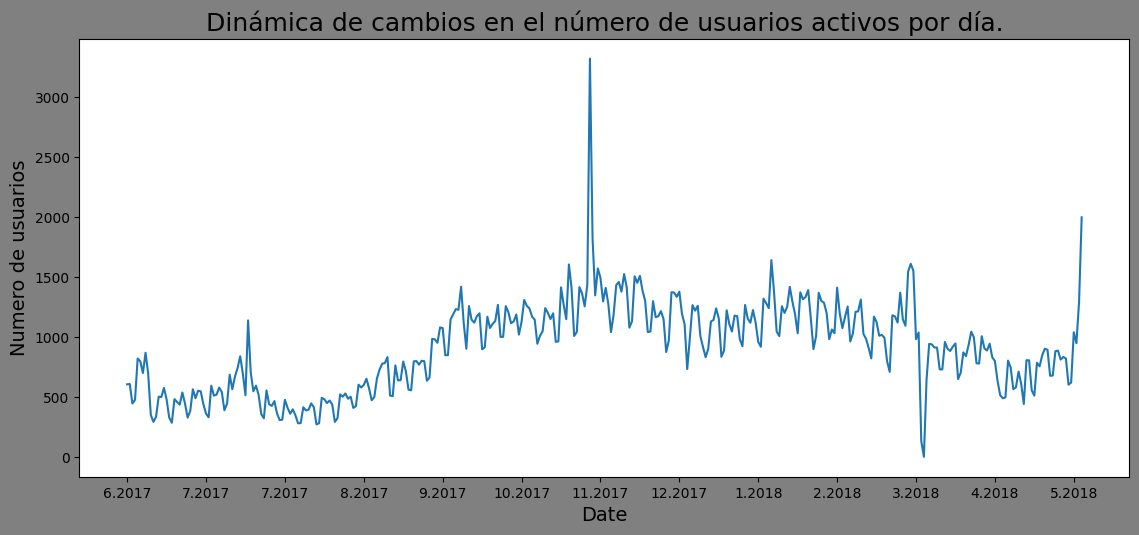

In [167]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(dau_graph["uid"])
x_pos = np.arange(len(dau_graph["uid"]))
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Numero de usuarios", fontsize=14)
ax.set_title(
    "Dinámica de cambios en el número de usuarios activos por día.", fontsize=18
)
fig.patch.set_facecolor("grey")
plt.xticks(x_pos, dau_graph["xticks"])
loc = ticker.MultipleLocator(base=30)
ax.xaxis.set_major_locator(loc)

plt.show()

Conclusión:

Claramente vemos fluctuaciones semanales en el gráfico, lo que significa que el número de usuarios en diferentes días de la semana no es el mismo. Como podemos ver, el número de usuarios únicos ha estado aumentando desde julio de 2017, pero en noviembre se detiene y comienza un declive gradual.

In [168]:
# MAU
mau_graph = visits.groupby(["year", "month"]).agg({"uid": "nunique"})
mau_graph = mau_graph.reset_index()

mau_graph["month"] = mau_graph["month"].astype("string")
mau_graph["year"] = mau_graph["year"].astype("string")

mau_graph["xticks"] = mau_graph["month"] + "." + mau_graph["year"]

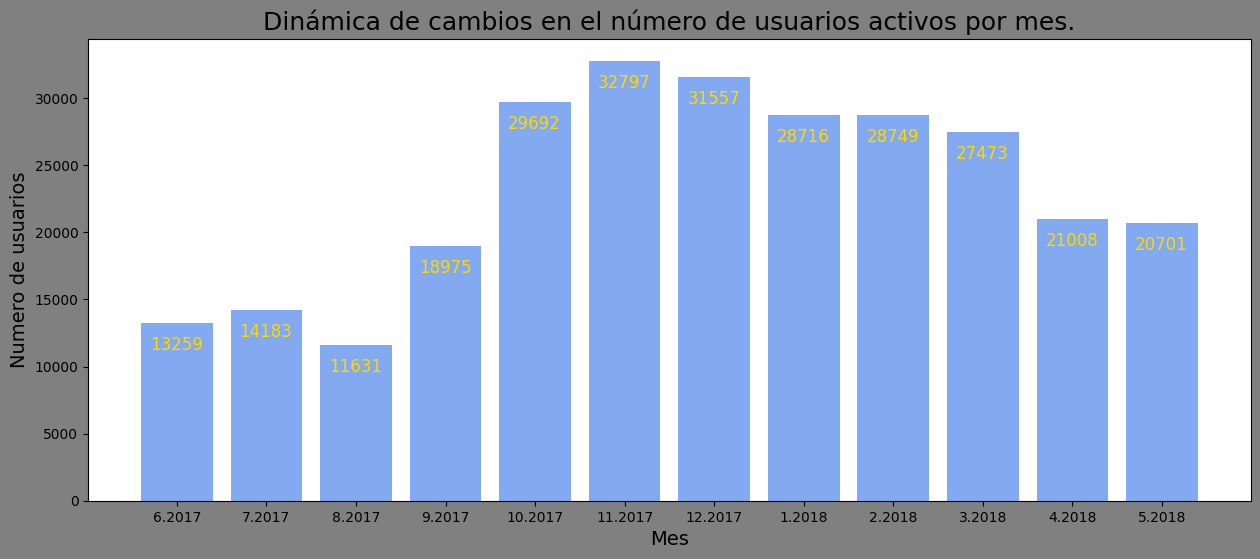

In [169]:
# Haciendo el grafico

n = len(mau_graph["xticks"])
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, mau_graph["uid"], align="center", alpha=0.8, color="cornflowerblue")

fig.patch.set_facecolor("grey")
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Numero de usuarios", fontsize=14)
plt.title("Dinámica de cambios en el número de usuarios activos por mes.", fontsize=18)
plt.xticks(ind, mau_graph["xticks"])
for idx, i in enumerate(ax.patches):
    ax.text(
        i.get_x() + 0.1,
        i.get_height() - 2000,
        int(mau_graph["uid"][idx]),
        fontsize=12,
        color="gold",
    )
plt.show()

Conclusión:

Como muestra el gráfico, el número de usuarios aumenta en invierno. El número mínimo de usuarios se observa en agosto. De agosto a noviembre, el número de usuarios se triplica.

**- Sticky Factor**

In [170]:
sticky_factor_w = dau / wau * 100
sticky_factor_m = dau / mau * 100
print("DAU/WAU es {:.2f}.".format(sticky_factor_w[0]))
print("DAU/MAU es {:.2f}.".format(sticky_factor_m[0]))

DAU/WAU es 15.88.
DAU/MAU es 3.91.


C:\Users\User\AppData\Local\Temp\ipykernel_24340\3241747355.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("DAU/WAU es {:.2f}.".format(sticky_factor_w[0]))
C:\Users\User\AppData\Local\Temp\ipykernel_24340\3241747355.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("DAU/MAU es {:.2f}.".format(sticky_factor_m[0]))


**- Graph 1. Sticky factor (DAU/MAU y DAU)**

In [171]:
visits["date"] = visits["start_ts"].dt.floor("1D")
min_date = visits["date"].min()  # date of first visit

dau_all_term = visits.groupby(["date"]).agg({"uid": "nunique"})
dau_all_term = dau_all_term.reset_index()

In [172]:
def fill_sticky_factor(item):
    # skip the first 30 days so that we can calculate the data for the first month
    if int((item - min_date) / np.timedelta64(1, "D")) > 29:
        dau_day_x = dau_all_term[dau_all_term["date"] == item]["uid"].min()
        maintime = item - pd.Timedelta(days=30)
        mau_day_x = visits.query("date <= @item and date > @maintime")["uid"].nunique()
        return dau_day_x / mau_day_x * 100
    else:
        return 0


dau_all_term["sticky_factor"] = dau_all_term["date"].apply(fill_sticky_factor)

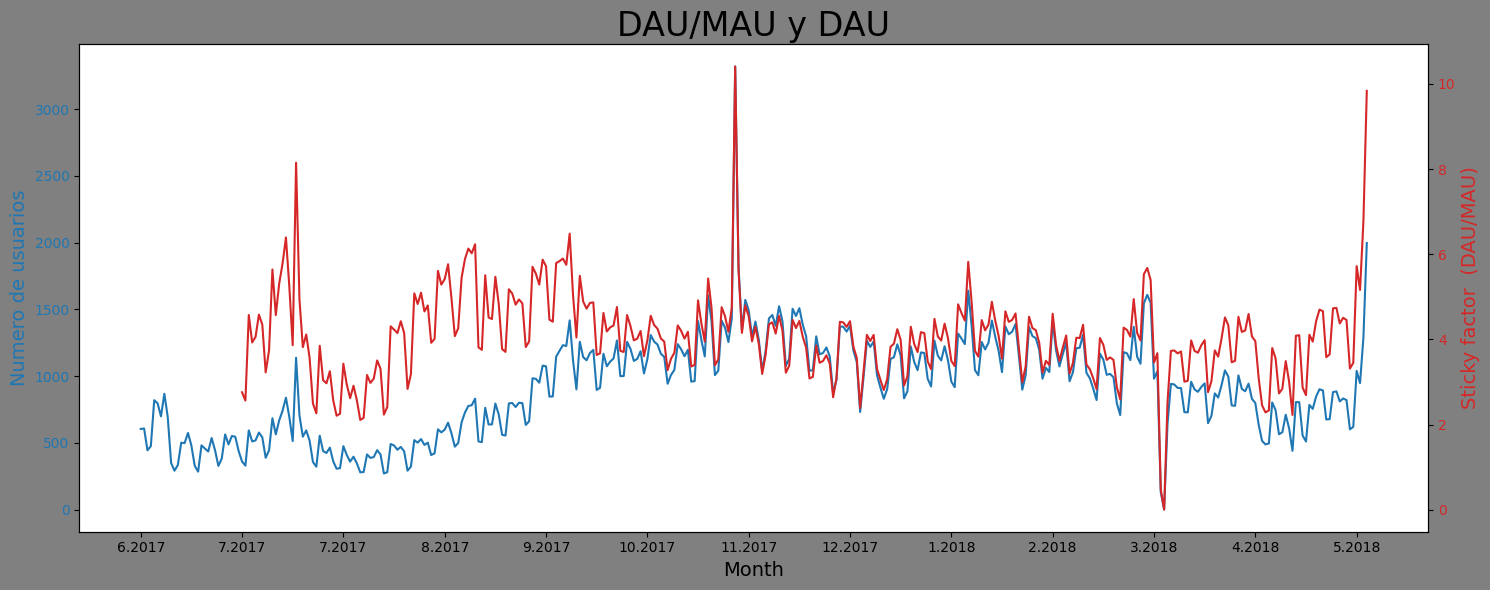

In [173]:
# graph 1. Sticky factor  (DAU/MAU y DAU)
fig, ax1 = plt.subplots(figsize=(15, 6))
color_ax1 = "tab:blue"
plt.plot(dau_graph["uid"], color=color_ax1)

x_pos = np.arange(len(dau_graph["uid"]))
fig.patch.set_facecolor("grey")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Numero de usuarios", fontsize=14, color=color_ax1)
plt.tick_params(axis="y", labelcolor=color_ax1)
plt.title("DAU/MAU y DAU", fontsize=24)
plt.xticks(x_pos, dau_graph["xticks"])
loc = ticker.MultipleLocator(base=30)
ax1.xaxis.set_major_locator(loc)

# plot graph 2.  Sticky factor
ax2 = ax1.twinx()  # crear una instancia de un segundo eje que comparte el mismo eje x
color_ax2 = "tab:red"
ax2.set_ylabel(
    "Sticky factor  (DAU/MAU)", color=color_ax2, fontsize=14
)  # ya manejamos la etiqueta x con ax1
ax2.plot(dau_all_term.query("sticky_factor > 0")["sticky_factor"], color=color_ax2)
ax2.tick_params(axis="y", labelcolor=color_ax2)
fig.tight_layout()  # de lo contrario, la etiqueta y derecha queda ligeramente recortada
plt.show()

Conclusión:

Como podemos ver, a partir de agosto de 2017 nuestros gráficos comenzaron a converger, lo que significa que los usuarios empezaron a usar nuestro servicio con menos frecuencia. Desde octubre, los gráficos han mantenido la misma dinámica, lo que indica que la disminución del interés en nuestro servicio se ha detenido. En marzo de 2018, el factor de retención comenzó a crecer más rápidamente que el DAU, lo que significa que los usuarios comenzaron a utilizar nuestro servicio con más frecuencia, lo cual es una buena noticia.

**- Graph 2. Sticky factor (DAU/MAU y MAU)**

In [174]:
dau_all_term["month"] = dau_all_term["date"].dt.month
dau_all_term["year"] = dau_all_term["date"].dt.year
dau_all_term["month"] = dau_all_term["month"].astype("string")
dau_all_term["year"] = dau_all_term["year"].astype("string")

dau_all_term["xticks"] = dau_all_term["month"] + "." + dau_all_term["year"]
dau_month = dau_all_term.groupby("xticks").agg({"sticky_factor": "mean"})
dau_month = dau_month.reset_index()
mau_graph = mau_graph.merge(dau_month, on="xticks")
pattern = mau_graph

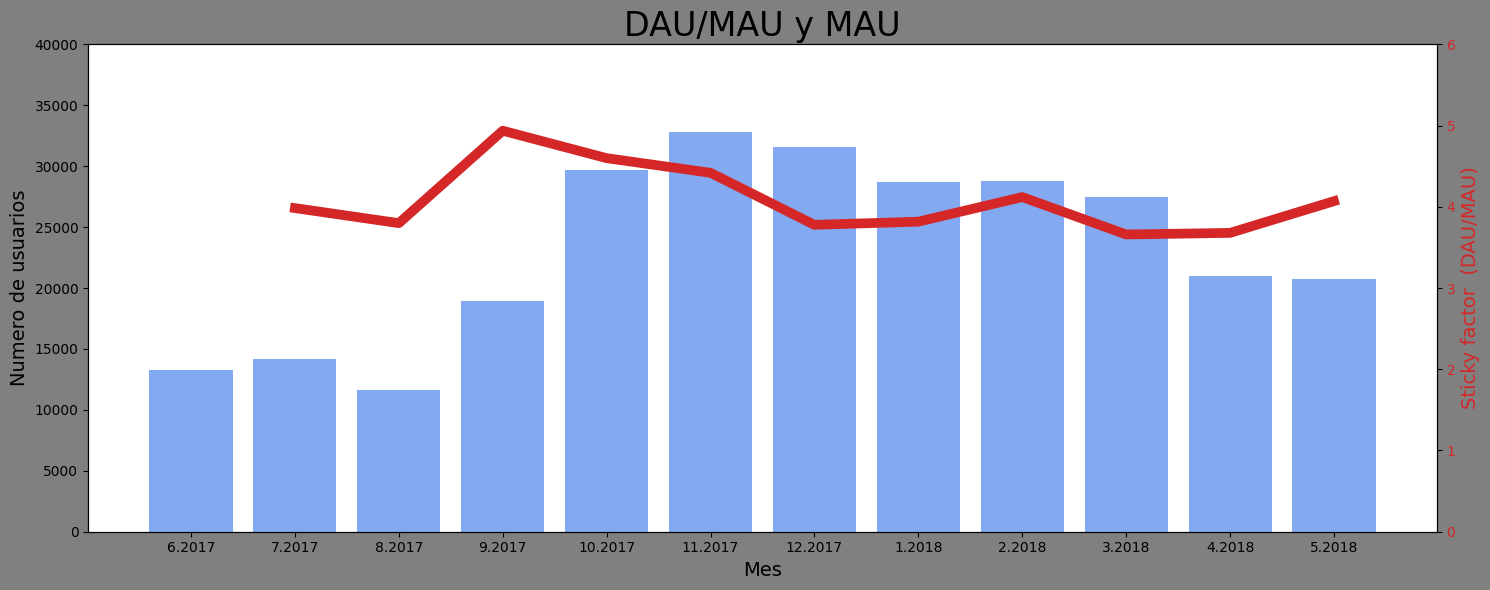

In [175]:
# Haciendo el grafico
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)
n = len(mau_graph["xticks"])
ind = np.arange(n)

fig, ax1 = plt.subplots(figsize=(15, 6))
plt.bar(ind, mau_graph["uid"], align="center", alpha=0.8, color="cornflowerblue")

fig.patch.set_facecolor("grey")
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Numero de usuarios", fontsize=14)
plt.title("DAU/MAU y MAU", fontsize=24)
plt.xticks(ind, mau_graph["xticks"])
ax1.set_ylim([0, 40000])


ax2 = ax1.twinx()  # crear una instancia de un segundo eje que comparte el mismo eje x
color = "tab:red"
ax2.set_ylabel(
    "Sticky factor  (DAU/MAU)", color=color, fontsize=14
)  # ya manejamos la etiqueta x con ax1
ax2.plot(
    mau_graph.query("sticky_factor > 0")["sticky_factor"], color=color, linewidth=7.0
)
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylim([0, 6])
fig.tight_layout()  # de lo contrario, la etiqueta y derecha queda ligeramente recortada
plt.show()

Conclusión:

El gráfico muestra que el factor de retención para los primeros 4 meses tuvo la misma dinámica que el MAU. Sin embargo, luego comenzó a disminuir, mientras que el MAU fue bastante estable de octubre de 2017 a marzo de 2018. Esto significa que el número de usuarios únicos por mes era estable y el número de usuarios únicos por día comenzó a disminuir, lo que indica que los usuarios empezaron a usar nuestro servicio con menos frecuencia. Sin embargo, en enero de 2018, la disminución se detuvo y vemos que el factor de retención ha comenzado a crecer, lo que indica que los usuarios han comenzado a utilizar nuestro servicio con más frecuencia.

- **El número de sesiones por día.**

In [176]:
sessions_per_day = visits.groupby(["year", "month", "day"]).agg({"uid": "count"})
sessions_per_day = sessions_per_day.rename(columns={"uid": "count_sessions"})
print("Número medio de sesiones por día. - {:}".format(int(sessions_per_day.mean())))

Número medio de sesiones por día. - 987


C:\Users\User\AppData\Local\Temp\ipykernel_24340\313232926.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print("Número medio de sesiones por día. - {:}".format(int(sessions_per_day.mean())))


In [177]:
sessions_per_day = sessions_per_day.reset_index().reset_index()
dau_graph = dau_graph.reset_index()

In [178]:
dau_graph = dau_graph.merge(sessions_per_day, on="index")
dau_graph = dau_graph[["index", "xticks", "uid", "count_sessions"]]

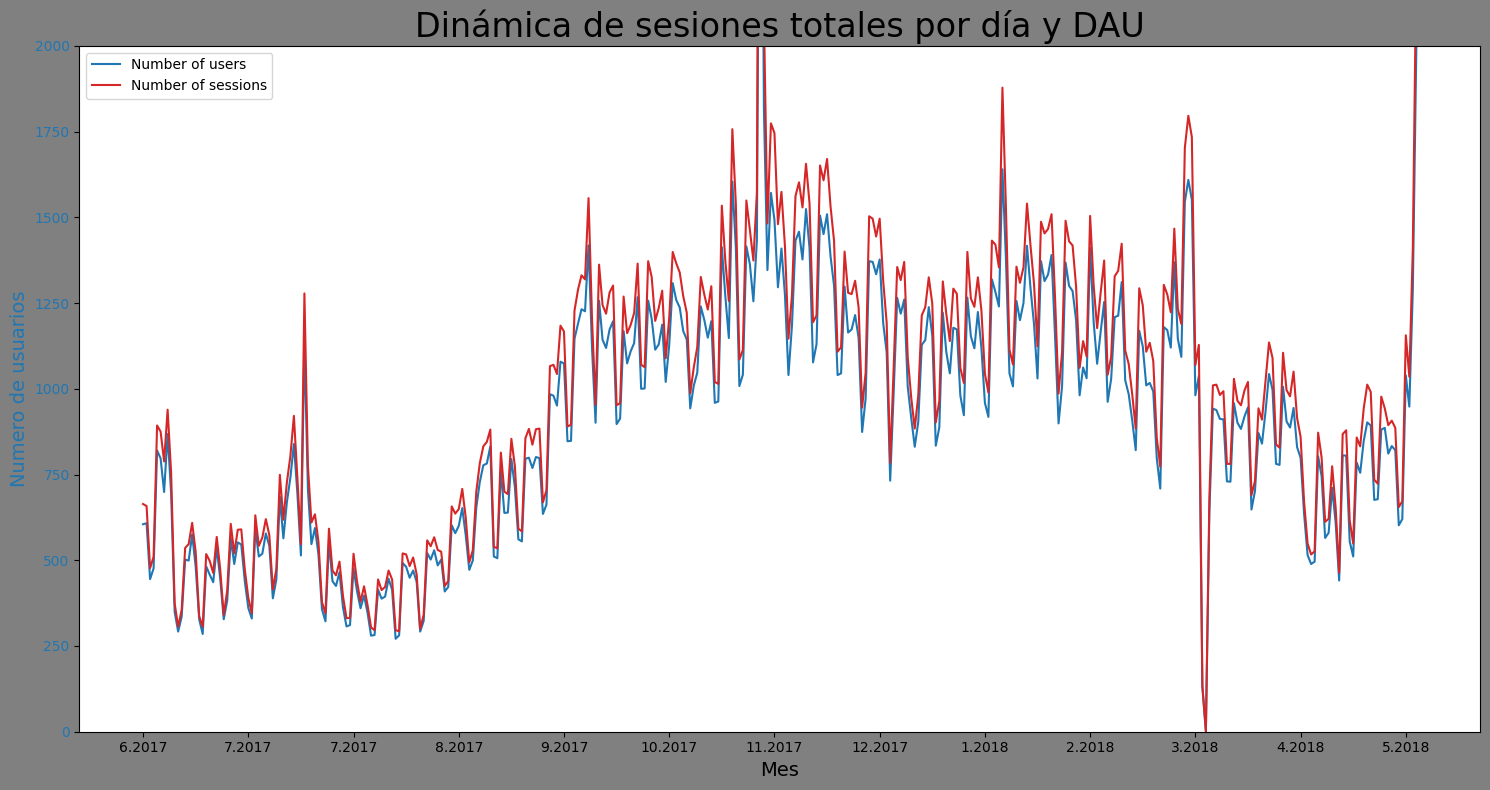

In [179]:
# graph 1. DAU (total sessions and DAU)
fig, ax1 = plt.subplots(figsize=(15, 8))
color_ax1 = "tab:blue"
color_ax2 = "tab:red"
plt.plot(dau_graph["uid"], color=color_ax1)
plt.plot(dau_graph["count_sessions"], color=color_ax2)

x_pos = np.arange(len(dau_graph["uid"]))
fig.patch.set_facecolor("grey")
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Numero de usuarios", fontsize=14, color=color_ax1)
plt.tick_params(axis="y", labelcolor=color_ax1)
plt.title("Dinámica de sesiones totales por día y DAU", fontsize=24)
plt.xticks(x_pos, dau_graph["xticks"])
loc = ticker.MultipleLocator(base=30)
ax1.xaxis.set_major_locator(loc)
ax1.set_ylim([0, 2000])
plt.legend(["Number of users", "Number of sessions"])

fig.tight_layout()
plt.show()

Conclusión:

Como podemos ver, el gráfico de "Número de sesiones" está siempre ligeramente por delante del gráfico de DAU. La ventaja es insignificante, lo que significa que muy raramente las personas usan el servicio varias veces al día.

- **El número medio de sesiones por usuario.**

In [180]:
dau_graph["number_sessions_per_user"] = dau_graph["count_sessions"] / dau_graph["uid"]

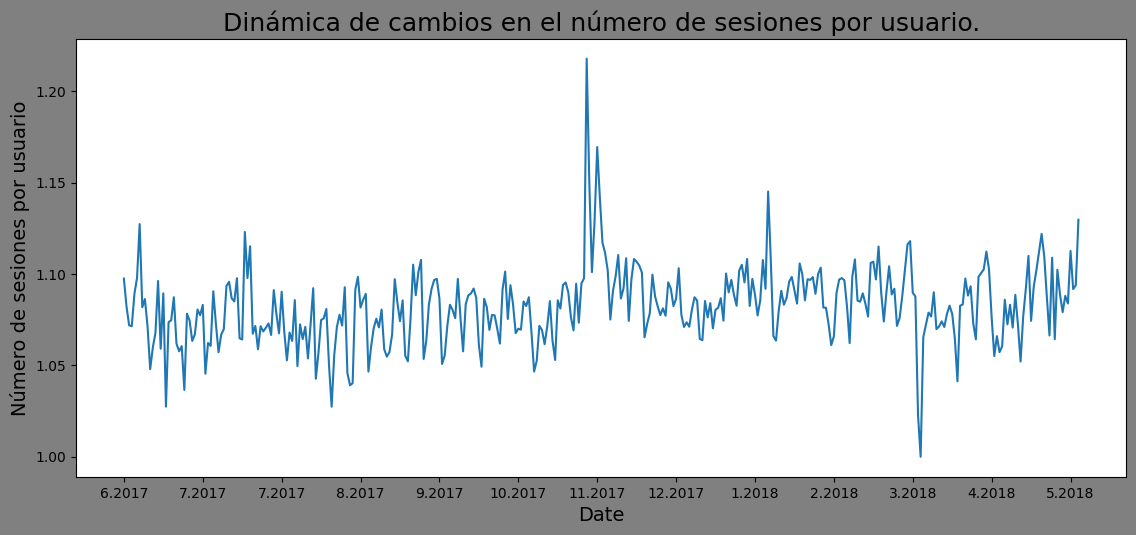

In [181]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(dau_graph["number_sessions_per_user"])
x_pos = np.arange(len(dau_graph["number_sessions_per_user"]))
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Número de sesiones por usuario", fontsize=14)
ax.set_title("Dinámica de cambios en el número de sesiones por usuario.", fontsize=18)
fig.patch.set_facecolor("grey")
plt.xticks(x_pos, dau_graph["xticks"])
loc = ticker.MultipleLocator(base=30)
ax.xaxis.set_major_locator(loc)

plt.show()

Conclusión:

Como podemos ver, durante todo el período de observación, el número de sesiones por usuario varía de 1.05 a 1.15. Esto significa que las personas no necesitan usar nuestro servicio varias veces al día.

- **Distribución de sesiones por tipo de dispositivo.**

In [182]:
sessions_touch = (
    visits[visits["device"] == "touch"]
    .groupby(["year", "month", "day"])
    .agg({"uid": "count"})
    .reset_index()
)
sessions_touch = sessions_touch.rename(columns={"uid": "count_sessions"})
sessions_desktop = (
    visits[visits["device"] == "desktop"]
    .groupby(["year", "month", "day"])
    .agg({"uid": "count"})
    .reset_index()
)
sessions_desktop = sessions_desktop.rename(columns={"uid": "count_sessions"})

In [183]:
def create_column_date(df):
    df["day"] = df["day"].astype("string")
    df["month"] = df["month"].astype("string")
    df["year"] = df["year"].astype("string")
    df["xticks"] = df["month"] + "." + df["year"]
    df["date"] = df["day"] + "." + df["month"] + "." + df["year"]
    return df


create_column_date(sessions_desktop)
create_column_date(sessions_touch)
sessions_desktop = sessions_desktop.rename(
    columns={"count_sessions": "column_name_desktop"}
)
sessions_touch = sessions_touch.rename(columns={"count_sessions": "column_name_touch"})
sessions_desktop = sessions_desktop.merge(sessions_touch, on="date")
sessions_desktop = sessions_desktop[
    ["column_name_desktop", "column_name_touch", "xticks_x", "date"]
]

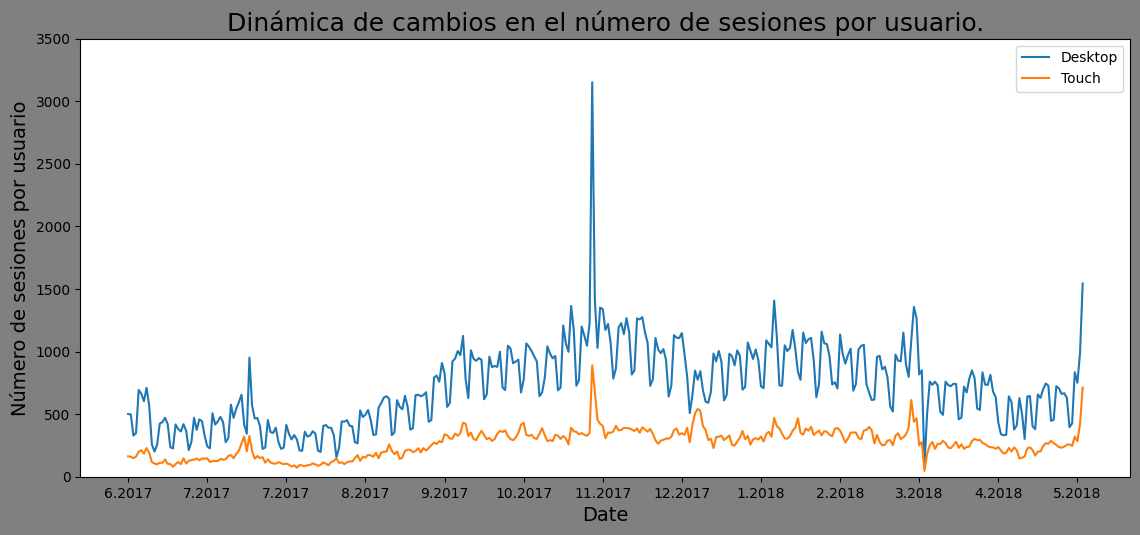

In [184]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(sessions_desktop["column_name_desktop"])
ax.plot(sessions_desktop["column_name_touch"])
x_pos = np.arange(len(sessions_desktop["column_name_touch"]))
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Número de sesiones por usuario", fontsize=14)
ax.set_title("Dinámica de cambios en el número de sesiones por usuario.", fontsize=18)
fig.patch.set_facecolor("grey")
plt.xticks(x_pos, sessions_desktop["xticks_x"])
loc = ticker.MultipleLocator(base=30)
ax.xaxis.set_major_locator(loc)
ax.set_ylim([0, 3500])
plt.legend(["Desktop", "Touch"])
plt.show()

Conclusión:

Como podemos ver en el gráfico, nuestro servicio se utiliza aproximadamente 3 veces más desde una computadora personal que desde un dispositivo móvil. El gráfico también muestra que los usuarios de teléfonos móviles utilizan los servicios de manera más uniforme durante toda la semana, mientras que los usuarios de PC tienen sesiones significativamente reducidas los fines de semana. Esto se debe al hecho de que un teléfono móvil siempre está con nosotros, mientras que muchos usuarios utilizan una PC en el trabajo.

- **Duración pr cada sesión**

In [185]:
visits["end_ts"] = pd.to_datetime(visits["end_ts"])
visits["start_ts"] = pd.to_datetime(visits["start_ts"])

visits["session_duration_sec"] = (visits["end_ts"] - visits["start_ts"]).dt.seconds

print(visits[["start_ts", "end_ts", "session_duration_sec"]].head())

             start_ts              end_ts  session_duration_sec
0 2017-12-20 17:20:00 2017-12-20 17:38:00                  1080
1 2018-02-19 16:53:00 2018-02-19 17:21:00                  1680
2 2017-07-01 01:54:00 2017-07-01 01:54:00                     0
3 2018-05-20 10:59:00 2018-05-20 11:23:00                  1440
4 2017-12-27 14:06:00 2017-12-27 14:06:00                     0


count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

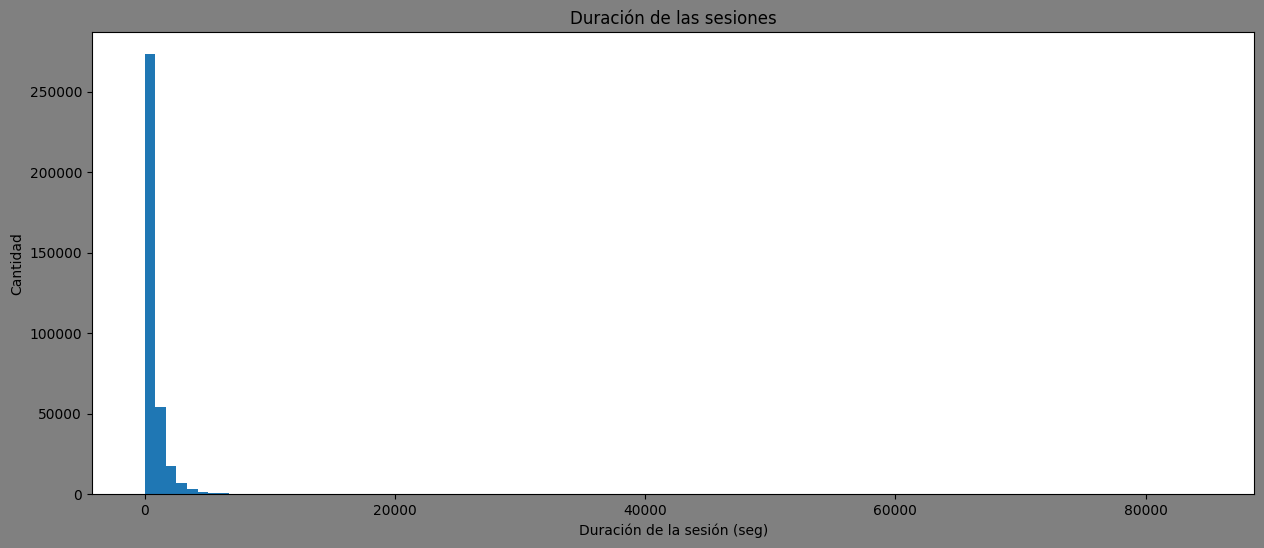

In [186]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.patch.set_facecolor("grey")
plt.hist(visits["session_duration_sec"], density=False, bins=100)
plt.title("Duración de las sesiones")
plt.ylabel("Cantidad")
plt.xlabel("Duración de la sesión (seg)")
# Data structure
visits["session_duration_sec"].describe()

Conclusion:

Como puede ver, el gráfico no es informativo, se puede suponer que existen valores atípicos. Descartemos los valores atípicos y construyamos un histograma.

In [187]:
# función atípica
def outliers_lower_upper(name_df, column):
    q1 = name_df[column].quantile(0.25)
    q3 = name_df[column].quantile(0.75)
    iqr = q3 - q1
    if q1 - iqr * 1.5 < 0:
        return (0, q3 + iqr * 1.5)
    else:
        return (q1 - iqr * 1.5, q3 + iqr * 1.5)


outliers_duration_sessions = outliers_lower_upper(visits, "session_duration_sec")
print('Los valores atípicos "Duración de las sesiones" son', outliers_duration_sessions)

Los valores atípicos "Duración de las sesiones" son (0, 1920.0)


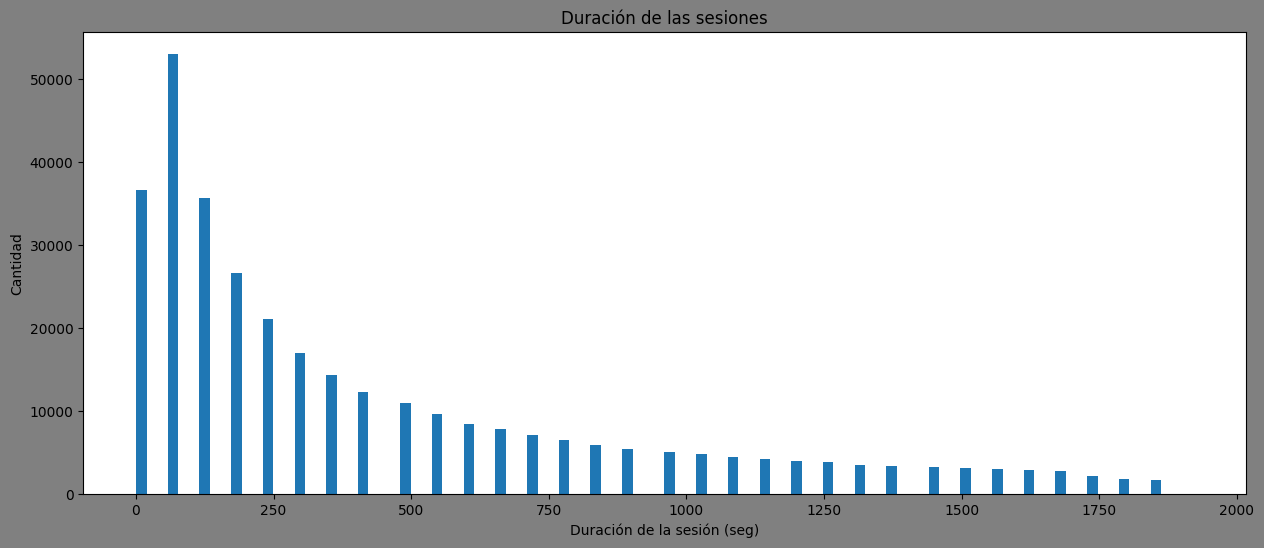

In [188]:
visits_without_outliers = visits[
    visits["session_duration_sec"] < outliers_duration_sessions[1]
]

fig, ax = plt.subplots(figsize=(15, 6))
fig.patch.set_facecolor("grey")
plt.hist(
    visits_without_outliers["session_duration_sec"],
    density=False,
    bins=100,
    range=(0, 1920),
)
plt.title("Duración de las sesiones")
plt.ylabel("Cantidad")
plt.xlabel("Duración de la sesión (seg)")
plt.show()

Conclusión:

La distribución es normal y podemos tomar la mediana para conocer la duración promedio de la sesión.

In [189]:
visit_avg_lenght = visits_without_outliers["session_duration_sec"].mean()
print("La duración promedio de la sesión es {:.0f} segunfos.".format(visit_avg_lenght))
asl = visits["session_duration_sec"].mode()
duration_zerro = len(visits_without_outliers.query("session_duration_sec == 0"))
print("La mayoría de las veces la sesión duró ", asl[0], " segundos.")
print(duration_zerro, " sesiones de 0 segundos.")

La duración promedio de la sesión es 438 segunfos.
La mayoría de las veces la sesión duró  60  segundos.
35794  sesiones de 0 segundos.


Conclusión:

La duración promedio de las sesiones fue de 7 minutos (438 segundos). Con mayor frecuencia, las sesiones duraron 1 minuto (60 segundos).
Hubo 35794 sesiones con una duración de 0 segundos, lo que significa que ocurrió un error de conexión y el usuario no pudo utilizar el servicio. Este error podría haber ocurrido en el lado del usuario (por ejemplo, el Internet no funcionaba bien) o en nuestro lado (por ejemplo, el servidor no funcionaba).

- **Dinámica de cambios en la duración de la sesión.**

In [190]:
duration = (
    visits_without_outliers.groupby(["year", "month", "day"])
    .agg({"session_duration_sec": "mean"})
    .reset_index()
)
duration["month"] = duration["month"].astype("string")
duration["year"] = duration["year"].astype("string")
duration["xticks"] = duration["month"] + "." + duration["year"]

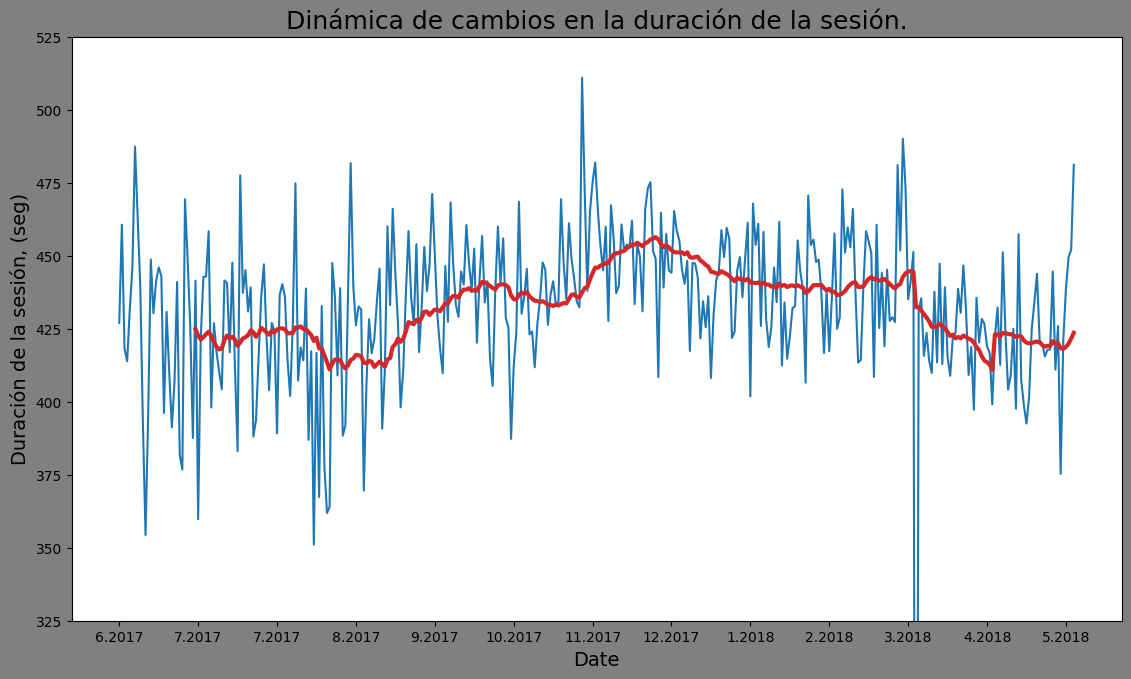

In [191]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(duration["session_duration_sec"])
x_pos = np.arange(len(duration["session_duration_sec"]))
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Duración de la sesión, (seg)", fontsize=14)
ax.set_title("Dinámica de cambios en la duración de la sesión.", fontsize=18)
fig.patch.set_facecolor("grey")
plt.xticks(x_pos, duration["xticks"])
loc = ticker.MultipleLocator(base=30)
ax.xaxis.set_major_locator(loc)
ax.set_ylim([325, 525])


# plot average line
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


NAvg = 30
XAvg = np.array(x_pos[NAvg - 1 :])
YAvg = moving_average(duration["session_duration_sec"], NAvg)
ax.plot(XAvg, YAvg, color=color, linewidth=3.0)

plt.show()

Conclusión:

Como podemos ver en el gráfico, desde agosto hasta diciembre, la duración de la sesión aumentó gradualmente, quizás hubo más ofertas y el usuario necesitaba más tiempo para elegir qué ordenar exactamente. Desde diciembre, ha habido una disminución gradual en la duración de la sesión.

- **¿Con qué frecuencia los usuarios y las usuarias regresan?**

In [192]:
# Copia del DataFrame original para trabajar en la retención de visitas
visits_retention = visits.copy()


def find_first_session(df, name_column, activity_type="first_session"):
    # Encontrar la fecha de la primera visita del usuario
    visits_first = df.groupby(["uid"]).agg({name_column: "min"}).reset_index()
    visits_first = visits_first.rename(columns={name_column: activity_type})
    df = df.merge(visits_first, on="uid", how="left")
    df[activity_type] = df[activity_type].dt.floor("1D")
    return df


def find_beginning_of_month_session(df):
    # Encontrar la fecha de la primera visita del usuario
    df = find_first_session(df, "date")
    # Encontrar el primer día del mes en el que tuvo lugar el primer contacto
    df["first_session"] = pd.to_datetime(df["first_session"]) - pd.to_timedelta(
        df["first_session"].dt.day - 1, unit="d"
    )
    # Encontrar el primer día del mes en el que tuvo lugar el contacto actual
    df["active_session"] = pd.to_datetime(df["date"]) - pd.to_timedelta(
        df["date"].dt.day - 1, unit="d"
    )
    return df


# Asegurarse de que 'date' es del tipo datetime
visits_retention["date"] = pd.to_datetime(visits_retention["start_ts"].dt.floor("1D"))

# Aplicar la función para encontrar el primer día del mes de la sesión
visits_retention = find_beginning_of_month_session(visits_retention)

# Verificar el resultado
print(visits_retention[["uid", "date", "first_session", "active_session"]].head())

                    uid       date first_session active_session
0  16879256277535980062 2017-12-20    2017-12-01     2017-12-01
1    104060357244891740 2018-02-19    2018-02-01     2018-02-01
2   7459035603376831527 2017-07-01    2017-07-01     2017-07-01
3  16174680259334210214 2018-05-20    2018-03-01     2018-05-01
4   9969694820036681168 2017-12-27    2017-12-01     2017-12-01


In [193]:
def calculate_cohort_lifetime(df):
    # Calculamos cuántos meses han pasado entre el contacto actual y el primer contacto
    df["cohort_lifetime"] = round(
        ((df["active_session"] - df["first_session"]) / np.timedelta64(1, "D")) / 30.44
    ).astype(int)

    # Contamos el número de usuarios únicos en cada cohorte cada mes
    cohorts = (
        df.groupby(["first_session", "cohort_lifetime"])
        .agg({"uid": "nunique"})
        .reset_index()
    )
    unique_users_first_month = cohorts[cohorts["cohort_lifetime"] == 0]
    unique_users_first_month = unique_users_first_month.rename(
        columns={"uid": "cohort_0", "cohort_lifetime": "cl2"}
    )
    cohorts = cohorts.merge(unique_users_first_month, on="first_session")

    # Calculamos la tasa de retención
    cohorts["retention"] = cohorts["uid"] / cohorts["cohort_0"]
    cohorts["first_month_str"] = cohorts["first_session"].dt.strftime("%Y.%m")

    # Agrupamos los datos para mostrar en un mapa de calor
    cohorts_pivot_table = cohorts.pivot_table(
        index="first_month_str",
        columns="cohort_lifetime",
        values="retention",
        aggfunc="sum",
    )
    return cohorts_pivot_table


# Aplicar la función para calcular la vida útil de la cohorte
cohorts_pivot_table = calculate_cohort_lifetime(visits_retention)

# Mostrar la tabla pivote de las cohortes
print(cohorts_pivot_table)

cohort_lifetime   0         1         2         3         4         5   \
first_month_str                                                          
2017.06          1.0  0.078664  0.053775  0.061392  0.068557  0.071423   
2017.07          1.0  0.056088  0.051294  0.056164  0.058219  0.048174   
2017.08          1.0  0.076908  0.062862  0.062764  0.050093  0.044004   
2017.09          1.0  0.085489  0.069205  0.050706  0.039392  0.037835   
2017.10          1.0  0.078608  0.052239  0.038958  0.034261  0.032221   
2017.11          1.0  0.078281  0.044113  0.038682  0.033727  0.023415   
2017.12          1.0  0.055802  0.037993  0.031107  0.020263  0.019036   
2018.01          1.0  0.059715  0.039339  0.024973  0.020244       NaN   
2018.02          1.0  0.057080  0.025454  0.020093       NaN       NaN   
2018.03          1.0  0.041818  0.027053       NaN       NaN       NaN   
2018.04          1.0  0.048380       NaN       NaN       NaN       NaN   
2018.05          1.0       NaN       N

Text(0.5, 58.7222222222222, 'Lifetime')

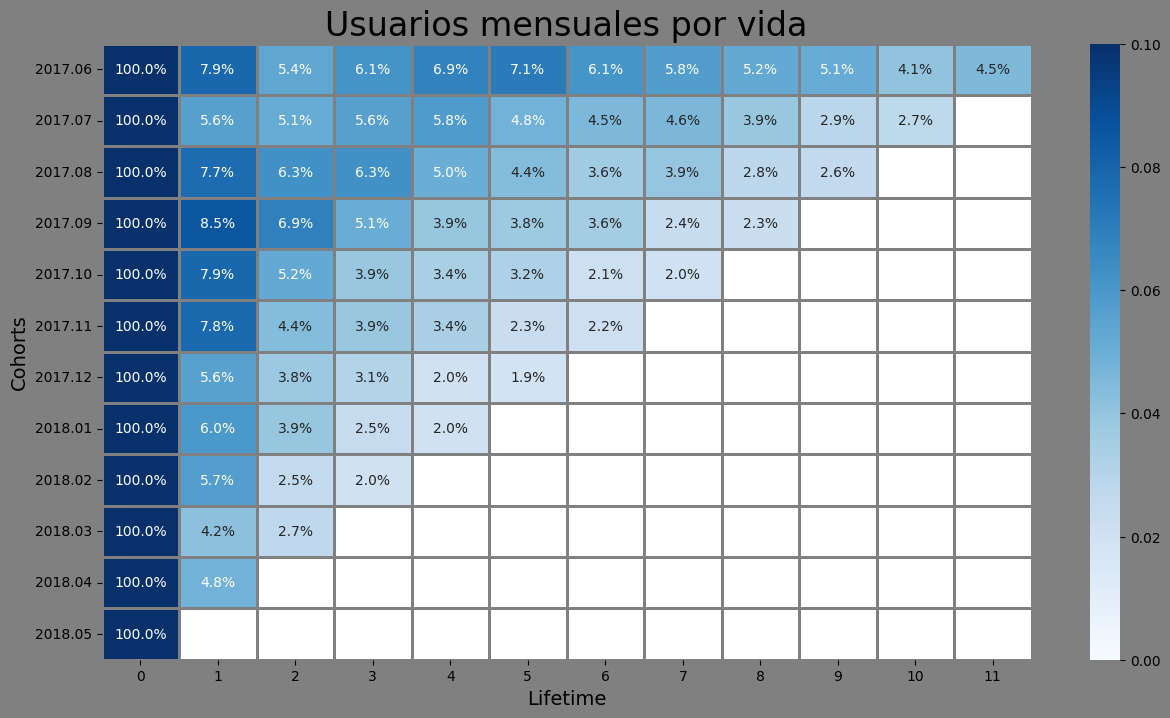

In [194]:
# Let's build a hotmap:
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor("grey")
plt.title("Usuarios mensuales por vida", fontsize=24)

sns.heatmap(
    cohorts_pivot_table,
    annot=True,
    fmt=".1%",
    linewidths=1,
    linecolor="grey",
    vmin=0,
    vmax=0.1,
    cmap="Blues",
)
ax.set_ylabel("Cohorts", fontsize=14)
ax.set_xlabel("Lifetime", fontsize=14)

Conclusión:

Como podemos ver, no más del 9% de los usuarios vuelven a acceder a nuestro servicio en los meses siguientes. Y cada mes la cantidad de usuarios disminuye. Es decir, gastamos dinero en atraer clientes, pero después de la primera experiencia de cooperación, la mayoría de los clientes no vuelven a contactarnos. Necesitamos averiguar las razones por las cuales los usuarios no estaban contentos y solucionarlas. Es mucho más barato retener a un cliente que atraer uno nuevo. A continuación, calcularemos cuántos usuarios nos han contactado más de una vez.

## 2. Ventas

- Cuanto tardan en realizar su primera compra


In [195]:
# Asegúrate de que la columna 'buy_ts' sea de tipo datetime
orders["buy_ts"] = pd.to_datetime(orders["buy_ts"])

# Encontrar la fecha del primer pedido en la tabla Orders
orders_first = orders.groupby("uid").agg({"buy_ts": "min"})
orders_first = orders_first.rename(columns={"buy_ts": "first_order"})

# Asegúrate de que la columna 'first_order' sea de tipo datetime
orders_first["first_order"] = orders_first["first_order"].dt.floor("1D")

# Mergear esta información con el DataFrame de visitas para obtener la fecha de registro y la primera compra
visits_orders = visits.merge(orders_first, on="uid", how="left")

# Asegúrate de que la columna 'date' (fecha de la primera visita) sea de tipo datetime
visits_orders["date"] = pd.to_datetime(visits_orders["date"])

# Calcular los días hasta la conversión
visits_orders["conversion_days"] = (
    visits_orders["first_order"] - visits_orders["date"]
).dt.days

# Clasificar las conversiones por días
visits_orders["conversion_category"] = visits_orders["conversion_days"].apply(
    lambda x: f"Conversion {x}d" if not pd.isnull(x) else "No Conversion"
)

# Mostrar los primeros resultados
print(
    visits_orders[
        ["uid", "date", "first_order", "conversion_days", "conversion_category"]
    ].head()
)

                    uid       date first_order  conversion_days  \
0  16879256277535980062 2017-12-20         NaT              NaN   
1    104060357244891740 2018-02-19         NaT              NaN   
2   7459035603376831527 2017-07-01         NaT              NaN   
3  16174680259334210214 2018-05-20  2018-03-09            -72.0   
4   9969694820036681168 2017-12-27         NaT              NaN   

  conversion_category  
0       No Conversion  
1       No Conversion  
2       No Conversion  
3   Conversion -72.0d  
4       No Conversion  


In [196]:
# Let's group the data about the first sessions
visits_conversion = visits[["device", "uid", "date", "source_id"]]
visits_conversion = visits_conversion.sort_values(by="date")

visits_conversion = visits_conversion.groupby("uid").agg(
    {"date": "min", "device": "first", "source_id": "first"}
)
visits_conversion = visits_conversion.rename(columns={"date": "first_session"})

In [197]:
# Let's combine the Orders_First and Visits_First tables
conversion_first = orders_first.merge(visits_conversion, on="uid", how="left")

In [198]:
# Let's calculate the conversion time
conversion_first["term"] = (
    (conversion_first["first_order"] - conversion_first["first_session"])
    / np.timedelta64(1, "D")
).astype("int")

print(conversion_first[[ "first_session", "first_order", "term"]].head())

                 first_session first_order  term
uid                                             
313578113262317     2017-09-18  2018-01-03   107
1575281904278712    2017-06-03  2017-06-03     0
2429014661409475    2017-10-11  2017-10-11     0
2464366381792757    2018-01-27  2018-01-28     1
2551852515556206    2017-11-24  2017-11-24     0


Conclusiones :

Conversiones inmediatas:

Muchos usuarios (e.g., uid 1575281904278712, uid 2429014661409475, uid 2551852515556206) compran el mismo día de su primera visita, lo que indica que algo en su primera experiencia fue lo suficientemente convincente.

Conversiones tardías:

Usuarios como uid 313578113262317 que tardan más de 100 días en convertir podrían necesitar más seguimiento y estrategias de engagement a largo plazo para mantener su interés hasta que se sientan listos para comprar.

Acciones de Marketing:

Comparar estos datos con campañas de marketing específicas puede revelar qué campañas son más efectivas para la conversión inmediata y cuáles necesitan ajustes para mejorar su efectividad.

In [199]:
# 1
avg_conversion = conversion_first["term"].mean()
print("La conversión promedio es {:.1f} dias.".format(avg_conversion))

La conversión promedio es 16.9 dias.


- **Conversiones por fuente de origen**

In [200]:
conversion_by_source = (
    conversion_first.groupby("source_id").agg({"term": ["mean", "count"]}).reset_index()
)
conversion_by_source.columns = ["source_id", "mean", "count"]
conversion_by_source["ratio_count"] = (
    conversion_by_source["count"] / conversion_by_source["count"].sum() * 100
)


def create_label(item):
    text = "Source " + str(int(item["source_id"]))
    return text


conversion_by_source["label"] = conversion_by_source.apply(create_label, axis=1)

In [201]:
conversion_by_source = conversion_by_source[
    conversion_by_source["mean"] != 0
].reset_index()

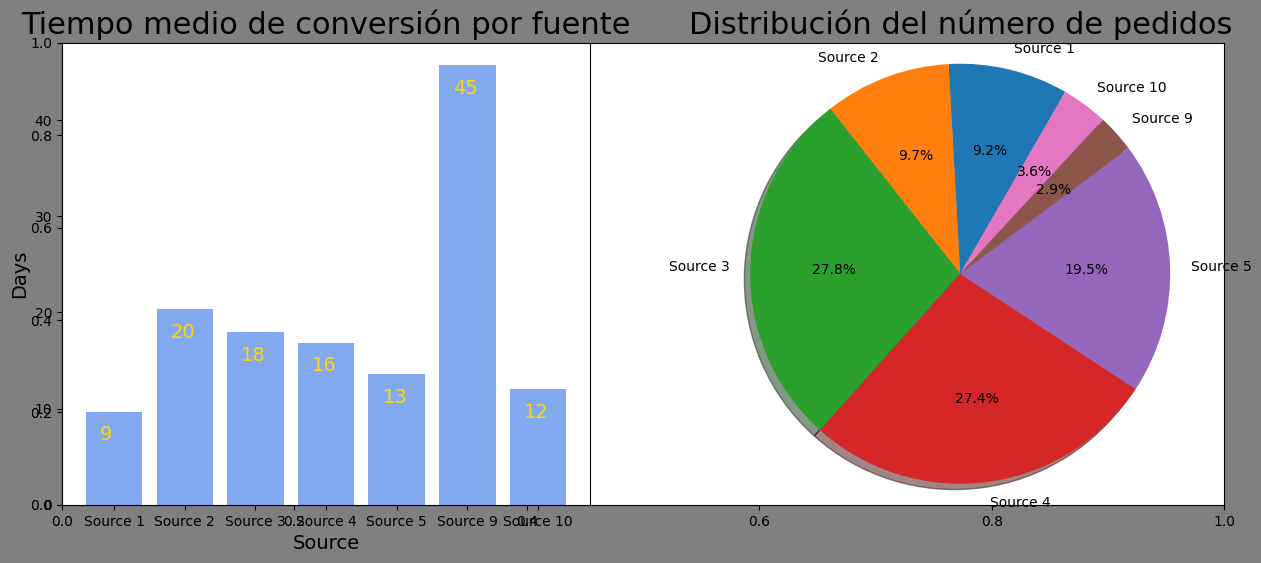

In [202]:
fig, ax1 = plt.subplots(figsize=(15, 6))
fig.patch.set_facecolor("grey")
ax1 = plt.subplot(121)

n = len(conversion_by_source["label"])
ind = np.arange(n)

res = plt.bar(
    ind, conversion_by_source["mean"], align="center", alpha=0.8, color="cornflowerblue"
)

plt.xlabel("Source", fontsize=14)
plt.ylabel("Days", fontsize=14)
plt.title("Tiempo medio de conversión por fuente", fontsize=22)
plt.xticks(ind, conversion_by_source["label"])
for idx, i in enumerate(ax1.patches):
    ax1.text(
        i.get_x() + 0.2,
        i.get_height() - 3,
        int(conversion_by_source["mean"][idx]),
        fontsize=14,
        color="gold",
    )

ax2 = plt.subplot(122)
res = ax2.pie(
    conversion_by_source["ratio_count"],
    #         explode = explode ,
    labels=conversion_by_source["label"],
    autopct="%1.1f%%",
    shadow=True,
    startangle=60,
)
ax2.axis(
    "equal"
)  # La relación de aspecto igual garantiza que el pastel se dibuje como un círculo.
ax2.set_title("Distribución del número de pedidos", fontsize=22)

plt.show()

Conclusión:

Como podemos ver, no hay pedidos de las fuentes 6, 7 y 8. Hay un período de conversión muy largo en la fuente 9. Quizás debido a ese período tan largo, solo el 2.9% de los pedidos provienen de la fuente 9. Las fuentes más populares son la 3 y la 4, con tiempos de conversión de 18 y 16 días, respectivamente. El mejor tiempo de conversión proviene de la fuente 1.

- **conversiones por plazos de tiempo**

In [203]:
# determinar el tipo de conversión
def type_conversion(term):
    if term == 0:
        return "Conversion 0d"
    if term <= 7:
        return "Conversion 7d"
    if term <= 14:
        return "Conversion 14d"
    if term <= 30:
        return "Conversion 30d"
    else:
        return "Conversion >30d"

In [204]:
# Calculemos las participaciones de cada tipo de conversión.
conversion_first["type_conversion"] = conversion_first["term"].apply(type_conversion)
conversion_shares = conversion_first.groupby("type_conversion").agg(
    {"type_conversion": "count"}
)
conversion_shares = conversion_shares.rename(columns={"type_conversion": "count"})
conversion_shares = conversion_shares.reset_index()
conversion_shares["ratio"] = (
    conversion_shares["count"] / conversion_shares["count"].sum() * 100
)

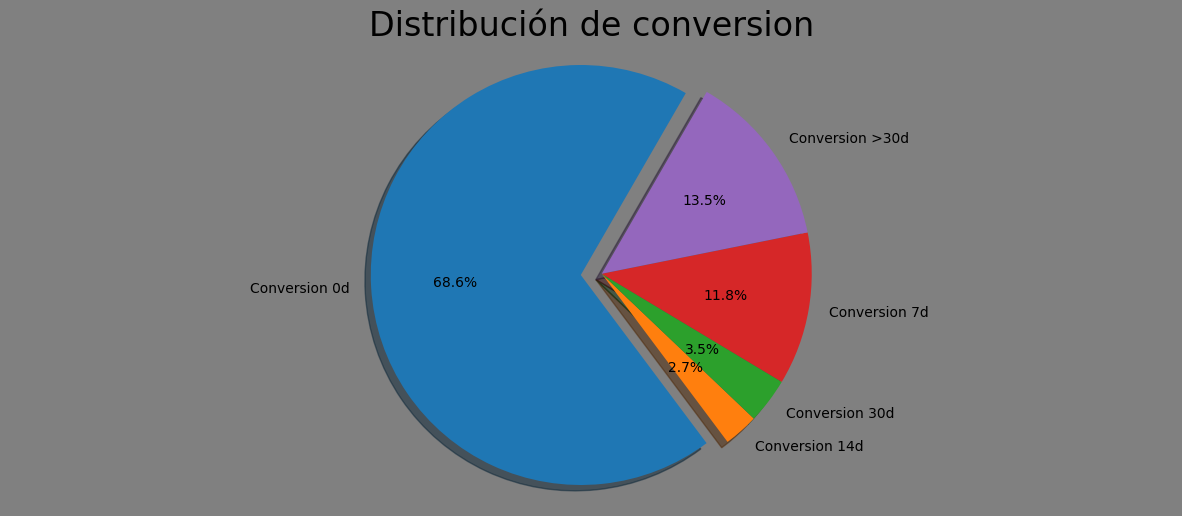

In [205]:
fig, ax1 = plt.subplots(figsize=(15, 6))
fig.patch.set_facecolor("grey")
explode = (0.1, 0, 0, 0, 0)
ax1.pie(
    conversion_shares["ratio"],
    explode=explode,
    labels=conversion_shares["type_conversion"],
    autopct="%1.1f%%",
    shadow=True,
    startangle=60,
)
ax1.axis(
    "equal"
)  # La relación de aspecto igual garantiza que el pastel se dibuje como un círculo.
ax1.set_title("Distribución de conversion", fontsize=24)
plt.show()

Conclusión:

Como podemos ver en el gráfico circular, el 68% de los pedidos se realizan el mismo día de la primera visita al sitio. El 11.8% de los usuarios realiza el pedido dentro de la primera semana después de la primera visita. Más del 13% realiza su primer pedido no antes de un mes después de la primera visita.

**- ¿Cuántos pedidos hacen durante un período de tiempo dado?**

In [206]:
orders_all = orders.merge(visits_conversion, on="uid", how="left")
orders_all["actual_date"] = orders_all["buy_ts"].dt.floor("1D")
# Contando el número de pedidos cada día para cada fuente
orders_per_day = orders_all.groupby(["actual_date", "source_id"], as_index=False).agg(
    {"device": "count"}
)
orders_per_day = orders_per_day.rename(columns={"device": "count_orders"})
orders_per_day["label"] = orders_per_day.apply(create_label, axis=1)
source_dict = orders_per_day.sort_values(by="source_id")["label"].unique().tolist()

In [207]:
# función para crear una tabla
def create_df_for_plot(type_source):
    df_source = orders_per_day.query("label == @type_source").pivot_table(
        index="actual_date", values="count_orders", aggfunc="sum"
    )
    return df_source

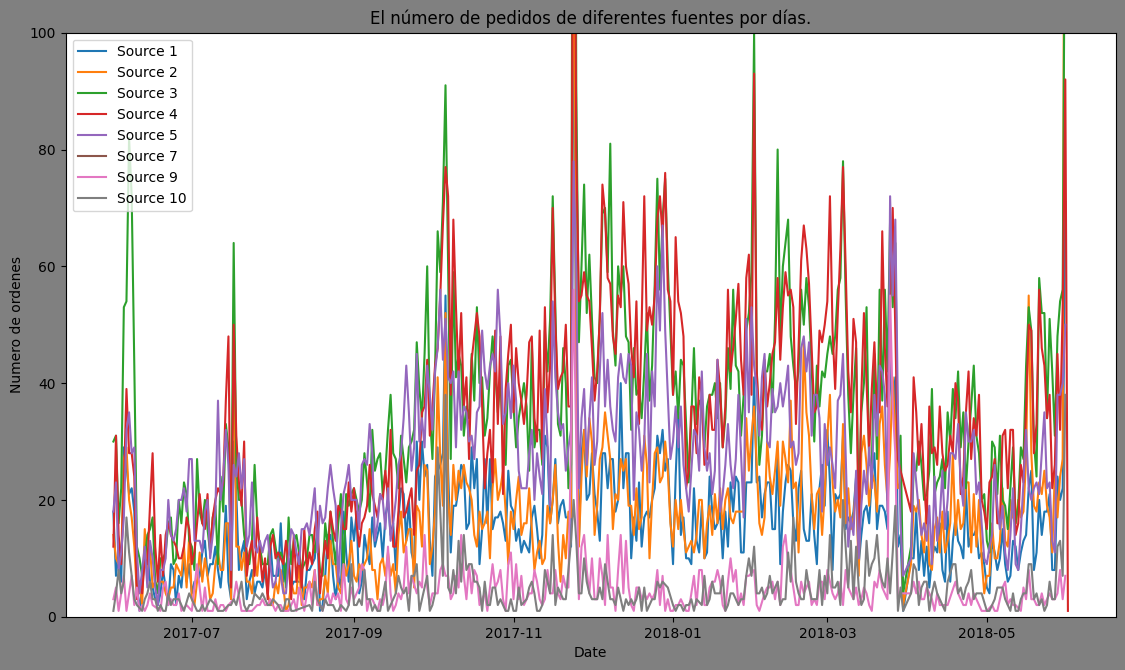

In [208]:
# Gráfico
fig, ax = plt.subplots(figsize=(15, 8))
fig.subplots_adjust(bottom=0.15, left=0.2)
for item in source_dict:
    ax.plot(create_df_for_plot(item))

ax.set_xlabel("Date")
ax.set_ylabel("Numero de ordenes")
plt.legend(source_dict)
ax.set_title("El número de pedidos de diferentes fuentes por días.")
ax.set_ylim([0, 100])
fig.patch.set_facecolor("grey")

plt.show()

Conclusión:

Como podemos ver, el gráfico es muy detallado y poco informativo. Es muy difícil percibir información de él. Vamos a construir un horario basado en el número de pedidos por semana.

- **Distribución semanal de ordenes por fuente**

In [209]:
# Encontrar el primer día de la semana.
orders_all["first_day_of_week"] = pd.to_datetime(
    orders_all["actual_date"], unit="d"
) - pd.to_timedelta(orders_all["actual_date"].dt.dayofweek, unit="d")
# Calculando el número de pedidos para esta semana
orders_per_week = orders_all.groupby(
    ["first_day_of_week", "source_id"], as_index=False
).agg({"device": "count"})
orders_per_week["label"] = orders_per_week.apply(create_label, axis=1)
orders_per_week = orders_per_week.rename(columns={"device": "count_orders"})

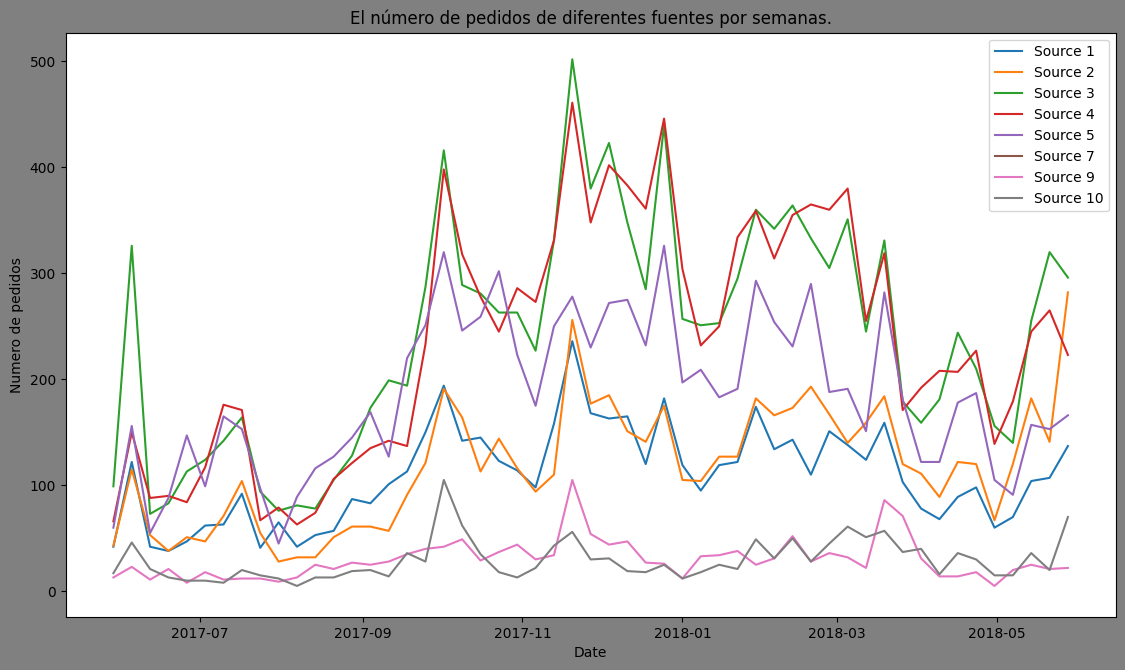

In [210]:
# haciendo graficos
fig, ax = plt.subplots(figsize=(15, 8))
fig.subplots_adjust(bottom=0.15, left=0.2)
for type_source in source_dict:
    ax.plot(
        orders_per_week.query("label == @type_source").pivot_table(
            index="first_day_of_week", values="count_orders", aggfunc="sum"
        )
    )
ax.set_xlabel("Date")
ax.set_ylabel("Numero de pedidos")
plt.legend(source_dict)
ax.set_title("El número de pedidos de diferentes fuentes por semanas.")
fig.patch.set_facecolor("grey")

plt.show()

Conclusión:

Como podemos ver, en agosto de 2017, los pedidos de todas las fuentes estaban aproximadamente en el mismo nivel, pero luego el número de pedidos de las fuentes 3, 4, 5, 2 y 1 comenzó a crecer. Los pedidos de las fuentes 3 y 4 han aumentado más que todas. Y de las fuentes 9 y 10, un número consistentemente bajo de pedidos.

- **Distribución por cohortes**

In [211]:
# Encontrar el primer día del mes.
orders_all["first_day_of_month_first_session"] = pd.to_datetime(
    orders_all["first_session"], unit="d"
) - pd.to_timedelta(orders_all["first_session"].dt.day - 1, unit="d")
# Calculando el número de pedidos para este mes.
orders_per_cohort = orders_all.groupby(
    ["first_day_of_month_first_session", "source_id"], as_index=False
).agg({"device": "count"})
orders_per_cohort["label"] = orders_per_cohort.apply(create_label, axis=1)
orders_per_cohort = orders_per_cohort.rename(columns={"device": "count_orders"})

In [212]:
# Encontraremos la proporción de pedidos de cada fuente en cada cohorte.
orders_cohort_all = orders_per_cohort.groupby("first_day_of_month_first_session").agg(
    {"count_orders": "sum"}
)
orders_cohort_all = orders_cohort_all.rename(
    columns={"count_orders": "count_orders_all"}
)
orders_per_cohort = orders_per_cohort.merge(
    orders_cohort_all, on="first_day_of_month_first_session"
)
orders_per_cohort["ratio"] = (
    orders_per_cohort["count_orders"] / orders_per_cohort["count_orders_all"]
)

In [213]:
# eliminando anomalías
orders_per_cohort = orders_per_cohort[
    (orders_per_cohort["label"] != "Source 7")
    & (orders_per_cohort["first_day_of_month_first_session"] != "2018-06-01")
]

orders_per_cohort["first_day_of_month_first_session"] = orders_per_cohort[
    "first_day_of_month_first_session"
].dt.strftime("%Y.%m")

orders_per_cohort_pivot_table = orders_per_cohort.pivot_table(
    index="first_day_of_month_first_session",
    columns="label",
    values="ratio",
    aggfunc="max",
)

Text(0.5, 58.7222222222222, 'Source')

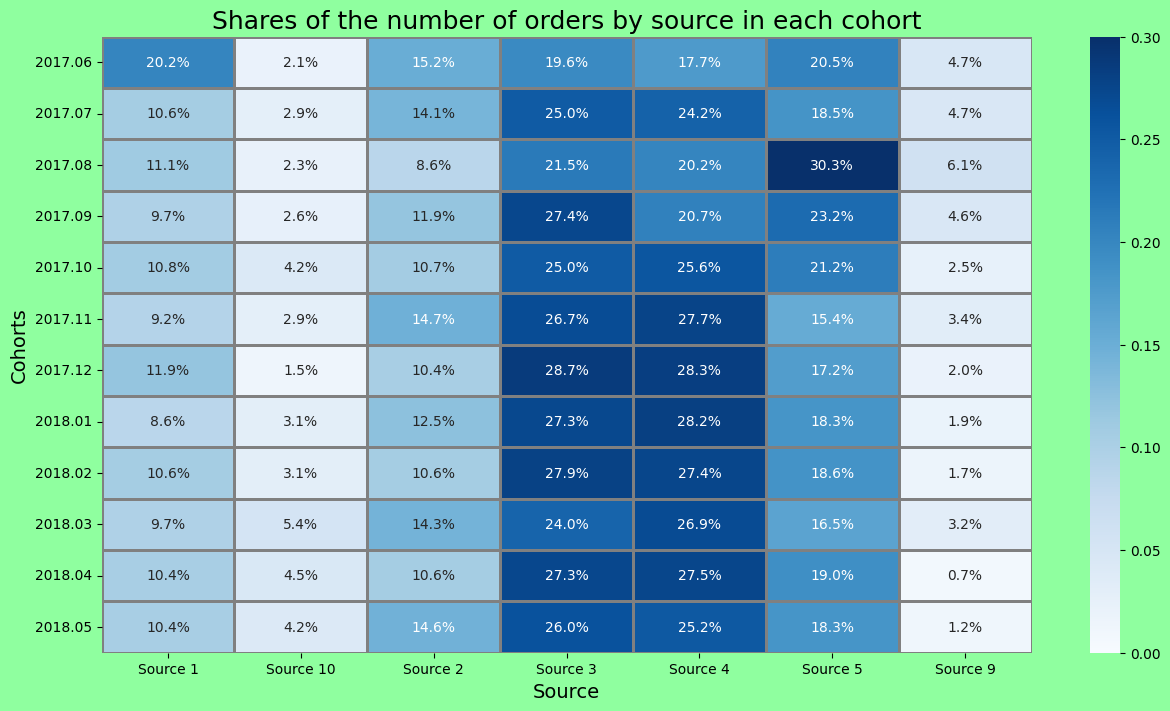

In [214]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor("xkcd:mint green")
plt.title("Shares of the number of orders by source in each cohort", fontsize=18)

sns.heatmap(
    orders_per_cohort_pivot_table,
    annot=True,
    fmt=".1%",
    linewidths=1,
    linecolor="grey",
    vmin=0,
    vmax=0.3,
    cmap="Blues",
    yticklabels=True,
)
ax.set_ylabel("Cohorts", fontsize=14)
ax.set_xlabel("Source", fontsize=14)

Conclusión:

Observamos que las participaciones de las Fuentes en diferentes cohortes son aproximadamente iguales. Sin embargo, existen excepciones. La participación de la Fuente N.º 1 en la primera cohorte es 2 veces mayor que en otras cohortes, y la participación de la Fuente N.º 5 en la tercera cohorte es notablemente más alta que en las demás. Se puede concluir que las participaciones cambian, pero no mucho.

**- ¿Cuál es el tamaño promedio de compra?**

In [215]:
revenue_per_day = orders_all.groupby(["actual_date"]).agg({"revenue": "mean"})

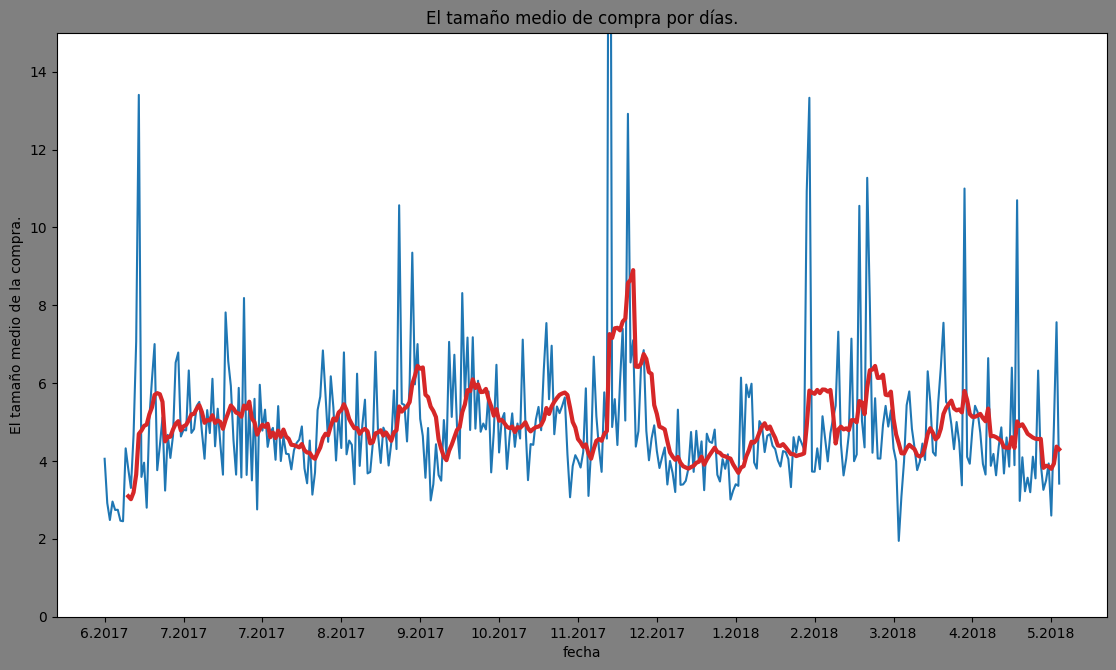

In [216]:
# Haciendo graficos
fig, ax = plt.subplots(figsize=(15, 8))
fig.subplots_adjust(bottom=0.15, left=0.2)
x_pos = np.arange(len(revenue_per_day))
XAvg = np.array(x_pos)
ax.plot(XAvg, revenue_per_day["revenue"])
ax.set_xlabel("fecha")
ax.set_ylabel("El tamaño medio de la compra.")
ax.set_title("El tamaño medio de compra por días.")
ax.set_ylim([0, 15])
fig.patch.set_facecolor("grey")

plt.xticks(x_pos, duration["xticks"])
loc = ticker.MultipleLocator(base=30)
ax.xaxis.set_major_locator(loc)
# línea promedio del plot
NAvg = 10
XAvg = np.array(x_pos[NAvg - 1 :])
YAvg = moving_average(revenue_per_day["revenue"], NAvg)
ax.plot(XAvg, YAvg, color=color, linewidth=3.0)

plt.show()

Conclusiones:

El precio promedio de compra oscila entre 4 y 6, con un aumento brusco en diciembre de 2017 a 9.

- **el tamaño promedio de las compras por fuente**

In [217]:
revenue_source = orders_all.groupby(["source_id"], as_index=False).agg(
    {"revenue": "mean"}
)
revenue_source["label"] = revenue_source.apply(create_label, axis=1)

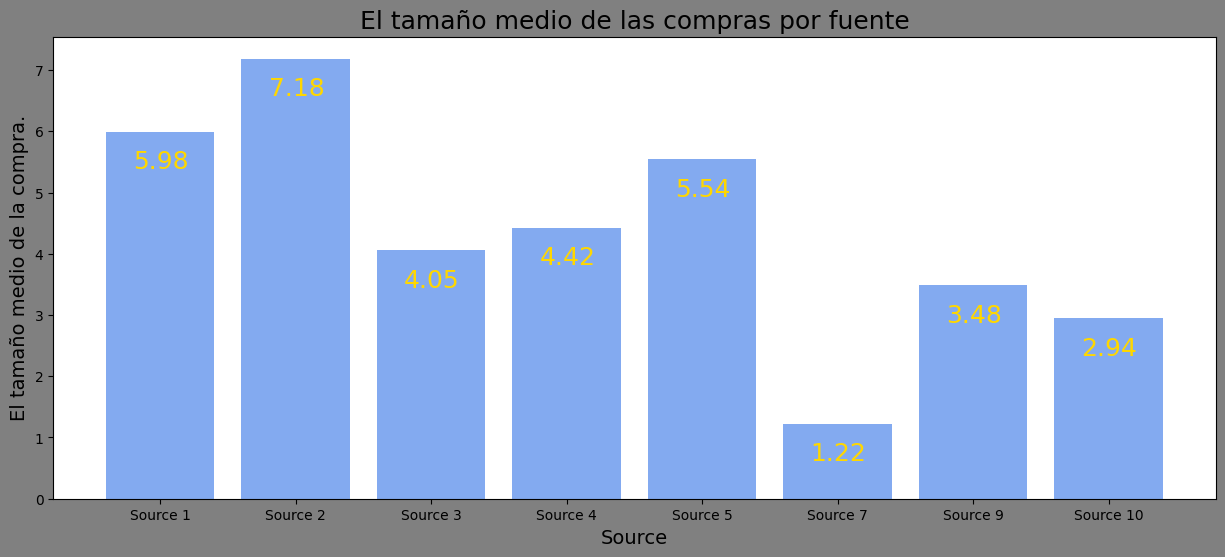

In [218]:
# creando plot

n = len(revenue_source["label"])
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(
    ind, revenue_source["revenue"], align="center", alpha=0.8, color="cornflowerblue"
)

fig.patch.set_facecolor("grey")
plt.xlabel("Source", fontsize=14)
plt.ylabel("El tamaño medio de la compra.", fontsize=14)
plt.title("El tamaño medio de las compras por fuente", fontsize=18)
plt.xticks(ind, revenue_source["label"])
for idx, i in enumerate(ax.patches):
    ax.text(
        i.get_x() + 0.2,
        i.get_height() - 0.6,
        float(int(revenue_source["revenue"][idx] * 100) / 100),
        fontsize=18,
        color="gold",
    )
plt.show()

Conclusion:
As we can see, the largest average revenue from resources 2, 1, and 5. From the most popular resources (3 and 4), the average revenue is not so high.

**- Cuánto dinero traen?**

- **por cliente**

In [219]:
ltv = orders_all.groupby("uid").agg({"revenue": "sum"}) 
ltv_avg = ltv.sum()[0] / len(ltv)
print("Beneficio medio por cliente ${:.1f}.".format(ltv_avg))

Average profit per client $6.9.


C:\Users\User\AppData\Local\Temp\ipykernel_24340\1375377142.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ltv_avg = ltv.sum()[0] / len(ltv)


- P**rofit promedio por cliente respecto a la fuente**

In [220]:
# Determinar de qué fuente fue la primera visita
orders_all = orders_all.sort_values(by="buy_ts")  
source_first = orders_all.groupby("uid").agg({"source_id": "first"})
source_first = source_first.rename(
    columns={"source_id": "source_id_first"}
)  
orders_all = orders_all.merge(source_first, on="uid")

In [221]:
# Cálculo del LTV de cada fuente
ltv_source_all = orders_all.groupby(["uid", "source_id_first"]).agg(
    {"revenue": "sum"}
)  
ltv_source = (
    ltv_source_all.groupby("source_id_first")
    .agg({"revenue": ["sum", "count"]})
    .reset_index()
)
ltv_source.columns = ["source_id", "sum", "count"]
ltv_source["ltv_customer"] = ltv_source["sum"] / ltv_source["count"]
ltv_source["label"] = ltv_source.apply(
    create_label, axis=1
)  # crear etiqueta para gráfico
ltv_source = ltv_source[
    ltv_source["label"] != "Source 7"
].reset_index()  #rechazar anomalía

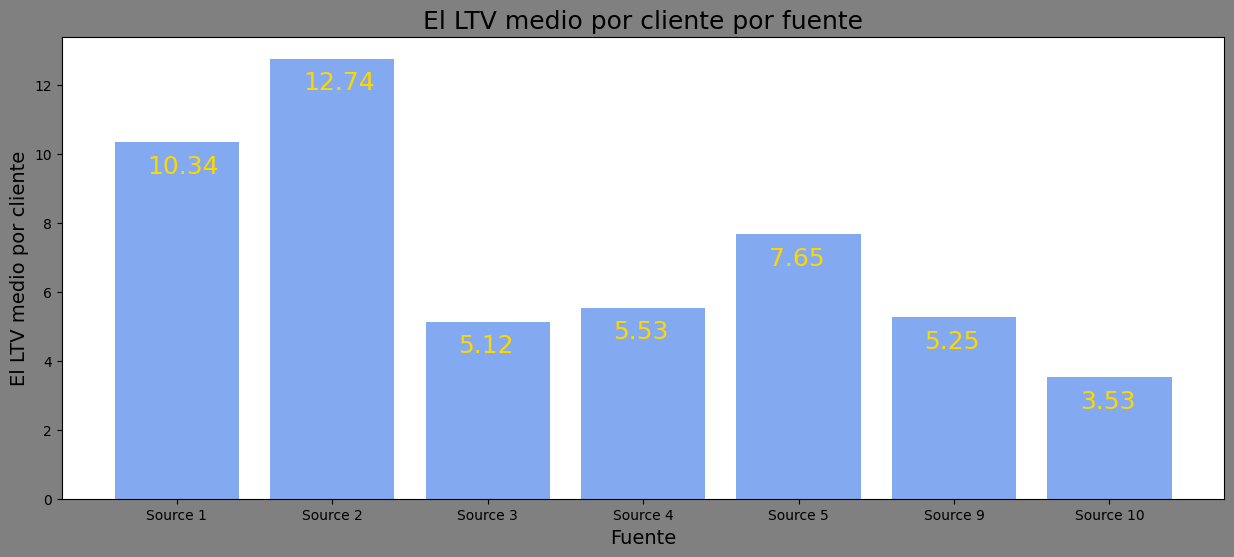

In [222]:
n = len(ltv_source["ltv_customer"])
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(
    ind, ltv_source["ltv_customer"], align="center", alpha=0.8, color="cornflowerblue"
)

fig.patch.set_facecolor("grey")
plt.xlabel("Fuente", fontsize=14)
plt.ylabel("El LTV medio por cliente", fontsize=14)
plt.title("El LTV medio por cliente por fuente", fontsize=18)
plt.xticks(ind, ltv_source["label"])
for idx, i in enumerate(ax.patches):
    ax.text(
        i.get_x() + 0.21,
        i.get_height() - 0.9,
        float(int(ltv_source["ltv_customer"][idx] * 100) / 100),
        fontsize=18,
        color="gold",
    )
plt.show()

Conclusión:

Como podemos ver, los LTV más grandes provienen de las fuentes 1 y 2. Si los costos de atracción de clientes de estas fuentes son rentables (como aprenderemos en la próxima sección), entonces es necesario aumentar el número de pedidos de estas fuentes. Como aprendimos anteriormente, estas fuentes representan aproximadamente el 10% de los pedidos.

- **Por cohort**

In [223]:
# Encontramos el primer día del mes en el que tuvo lugar el contacto actual.
orders_all['first_day_of_month_actual_order'] = (
    pd.to_datetime(orders_all['actual_date'], unit='d') 
    -
    pd.to_timedelta(orders_all['actual_date'].dt.day - 1, unit='d') )

In [224]:
# Asegurándonos de que las fechas estén en el formato correcto
orders_all["actual_date"] = pd.to_datetime(orders_all["actual_date"])
orders_all["first_day_of_month_first_session"] = pd.to_datetime(
    orders_all["first_day_of_month_first_session"]
)

# Encontramos el primer día del mes en el que ocurrió la orden actual
orders_all["first_day_of_month_actual_order"] = orders_all[
    "actual_date"
] - pd.to_timedelta(orders_all["actual_date"].dt.day - 1, unit="d")

# Calculamos cuántos meses han pasado entre la orden actual y la primera sesión
orders_all["cohort_lifetime"] = (
    orders_all["first_day_of_month_actual_order"]
    - orders_all["first_day_of_month_first_session"]
).dt.days // 30

# Revisión de los resultados
print(
    orders_all[
        [
            "actual_date",
            "first_day_of_month_actual_order",
            "first_day_of_month_first_session",
            "cohort_lifetime",
        ]
    ].head()
)

  actual_date first_day_of_month_actual_order  \
0  2017-06-01                      2017-06-01   
1  2017-06-01                      2017-06-01   
2  2017-06-01                      2017-06-01   
3  2017-06-01                      2017-06-01   
4  2017-06-01                      2017-06-01   

  first_day_of_month_first_session  cohort_lifetime  
0                       2017-06-01                0  
1                       2017-06-01                0  
2                       2017-06-01                0  
3                       2017-06-01                0  
4                       2017-06-01                0  


In [225]:
# calcular el número de usuarios únicos en cada cohorte cada mes
cohorts_ltv = (
    orders_all.query('actual_date != "2018-06-01"')
    .groupby(["first_day_of_month_first_session", "cohort_lifetime"])
    .agg({"revenue": ["sum", "count"]})
    .reset_index()
    .reset_index()
)
cohorts_ltv.columns = [
    "index",
    "first_day_of_month_first_session",
    "cohort_lifetime",
    "revenue",
    "count_orders",
]
# contando el número de clientes en cada cohorte
cohorts_ltv_0 = (
    orders_all.groupby("first_day_of_month_first_session")
    .agg({"uid": "nunique"})
    .reset_index()
)
cohorts_ltv_0 = cohorts_ltv_0.rename(columns={"uid": "count_orders_all"})
cohorts_ltv = cohorts_ltv.merge(cohorts_ltv_0, on="first_day_of_month_first_session")

In [226]:
# Calculemos la cantidad total de compras en cada cohorte.
cohorts_cumsum = (
    cohorts_ltv.groupby("first_day_of_month_first_session")
    .agg({"revenue": "cumsum"})
    .reset_index()
)
cohorts_cumsum = cohorts_cumsum.rename(columns={"revenue": "revenue_all"})
cohorts_ltv = cohorts_ltv.merge(cohorts_cumsum, on="index")
cohorts_ltv["revenue_per_user"] = (
    cohorts_ltv["revenue_all"] / cohorts_ltv["count_orders_all"]
)
cohorts_ltv = cohorts_ltv[
    cohorts_ltv["first_day_of_month_first_session"] != "2018-06-01"
]
cohorts_ltv["first_day_of_month_first_session_str"] = cohorts_ltv[
    "first_day_of_month_first_session"
].dt.strftime("%Y.%m")

In [227]:
# Creemos una tabla dinámica con información LTV para cada cohorte.
cohorts_ltv_pivot_table = cohorts_ltv.pivot_table(
    index="first_day_of_month_first_session_str",
    columns="cohort_lifetime",
    values="revenue_per_user",
    aggfunc="sum",
)

Text(0.5, 58.7222222222222, 'Cohort Lifetime')

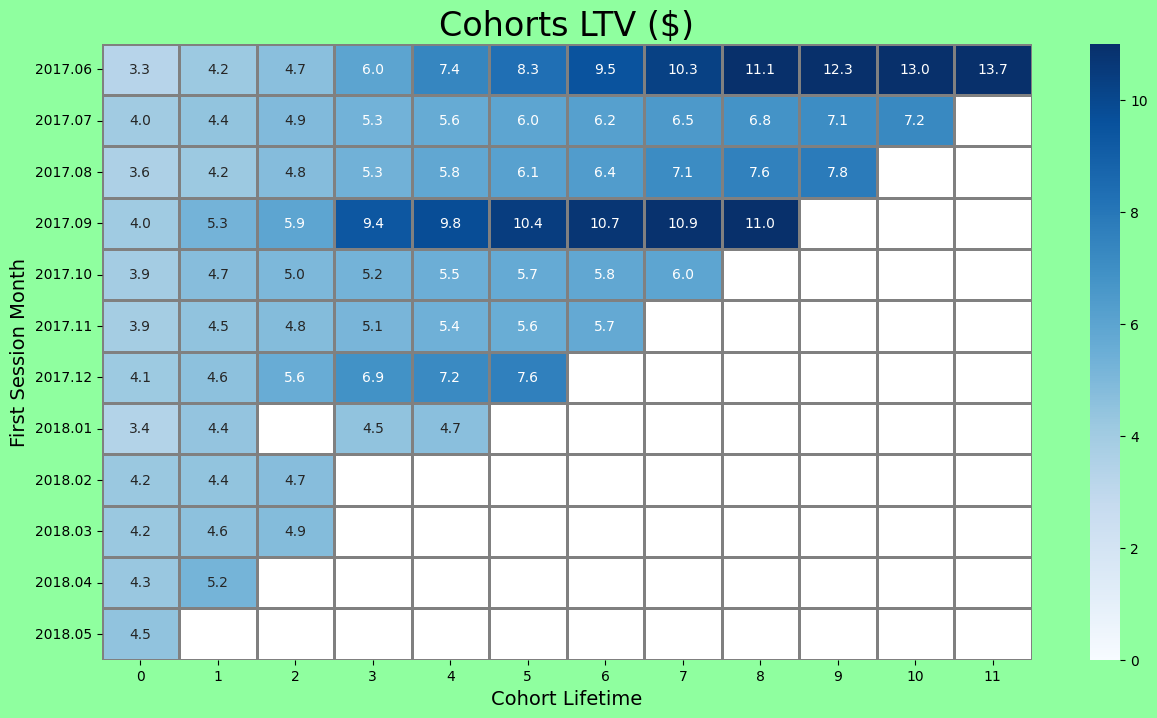

In [228]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor("xkcd:mint green")
plt.title("Cohorts LTV ($)", fontsize=24)

sns.heatmap(
    cohorts_ltv_pivot_table,
    annot=True,
    fmt=".1f",
    linewidths=1,
    linecolor="grey",
    vmin=0,
    vmax=11,
    cmap="Blues",
)
ax.set_ylabel("First Session Month", fontsize=14)
ax.set_xlabel("Cohort Lifetime", fontsize=14)

Conclusión:

En promedio, cada cliente de la primera cohorte generó 13.7 dólares en ingresos durante su vida útil de once meses. Como podemos ver, no todas las cohortes generan el mismo beneficio por cliente. Las más rentables fueron las primeras 4 cohortes. También hay un aumento inesperadamente brusco en el LTV en la cuarta cohorte en el cuarto mes, pasando de 5.9 a 9.4.

## 2.3 MARKETING

**- ¿Cuánto dinero se gastó? (Total/por fuente de adquisición/a lo largo del tiempo)**

- **Diario**

In [229]:
costs  
costs_daily = costs.groupby("dt").agg({"costs": "sum"})

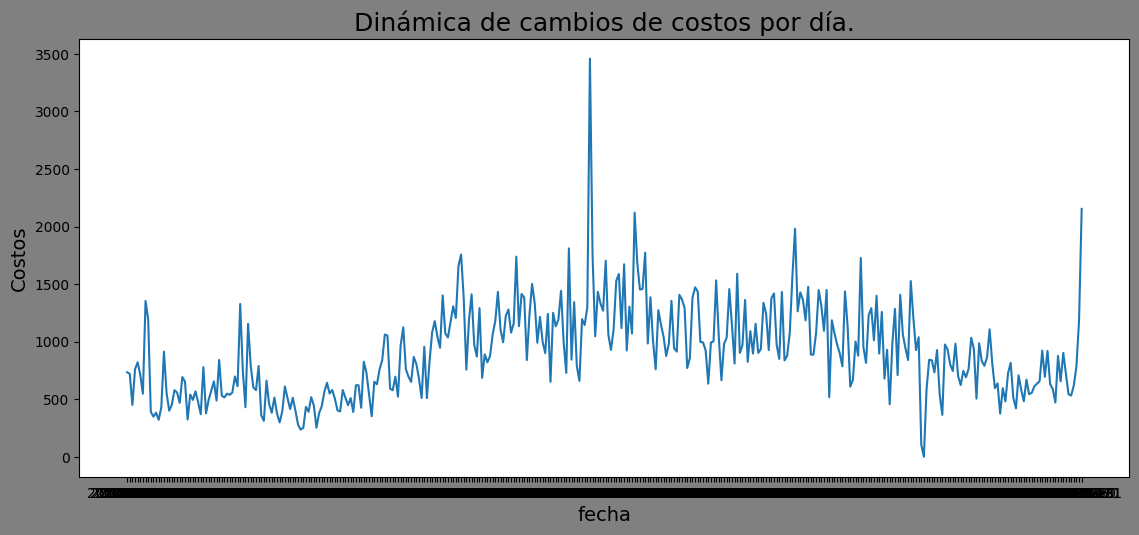

In [230]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(
    costs_daily,
)
ax.set_xlabel("fecha", fontsize=14)
ax.set_ylabel("Costos", fontsize=14)
ax.set_title("Dinámica de cambios de costos por día.", fontsize=18)
fig.patch.set_facecolor("grey")


plt.show()

Conclusión:

Este gráfico es muy similar al número de visitas por día. Esto no es sorprendente, ya que las visitas dependen directamente de los fondos gastados. Desde agosto hemos visto un aumento en los costos. Desde octubre hasta marzo, los costos están aproximadamente en el mismo nivel, y a partir de marzo, el costo de adquirir clientes ha estado disminuyendo. También observamos un aumento brusco diario en los costos el 24 de noviembre de 2017, de 1.200 a 3.500. Esto explica por qué en las partes anteriores vimos un número anormal de pedidos, visitas e ingresos en el mismo período.

**- ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?**

In [231]:
costs_source = costs.groupby("source_id").agg({"costs": "sum"}).reset_index()
costs_source["label"] = costs_source.apply(
    create_label, axis=1
)  

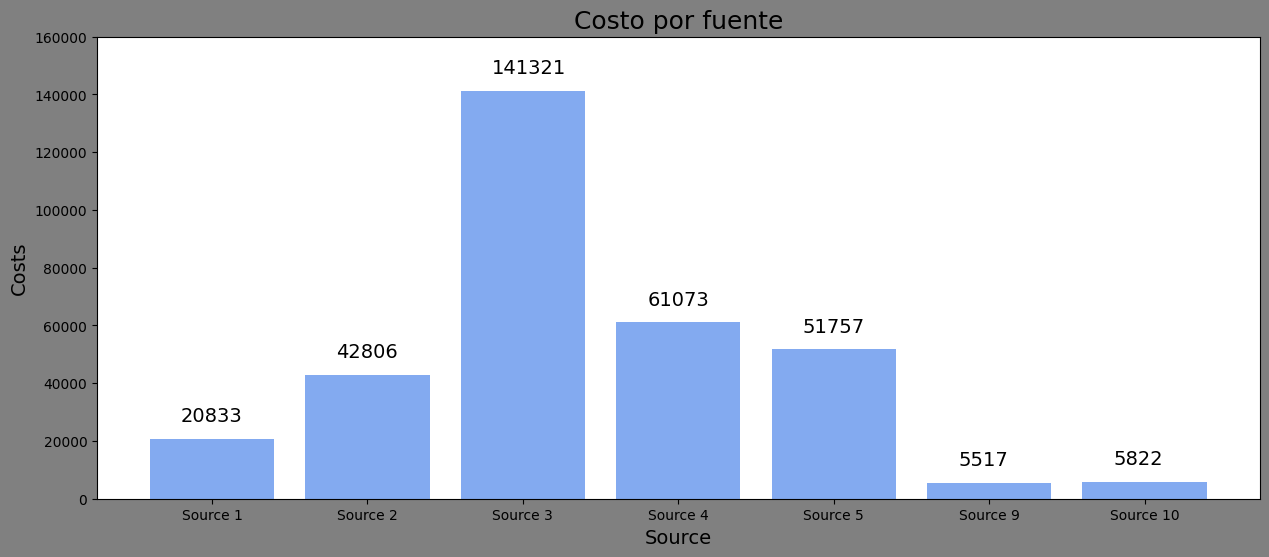

In [232]:
# creando plot
n = len(costs_source["costs"])
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, costs_source["costs"], align="center", alpha=0.8, color="cornflowerblue")

fig.patch.set_facecolor("grey")
plt.xlabel("Source", fontsize=14)
plt.ylabel("Costs", fontsize=14)
plt.title("Costo por fuente", fontsize=18)
plt.xticks(ind, costs_source["label"])
ax.set_ylim([0, 160000])
for idx, i in enumerate(ax.patches):
    ax.text(
        i.get_x() + 0.2,
        i.get_height() + 6000,
        int(costs_source["costs"][idx]),
        fontsize=14,
        color="black",
    )
plt.show()

Conclusión:

Como podemos ver, los costos más altos para la Fuente 3 son más de 2,5 veces superiores a los de la Fuente 4; sin embargo, como determinamos anteriormente, las Fuentes 3 y 4 generan aproximadamente la misma cantidad de pedidos. Obviamente, el presupuesto publicitario debe ser redistribuido entre las Fuentes 3 y 4.

- **El costo de atraer clientes por fuente**


In [233]:
# Contemos el número de clientes de cada fuente.
source_number_buyers = (
    orders_all.query("source_id != 7")
    .groupby("source_id", as_index=False)
    .agg({"uid": "nunique"})
)
costs_source = costs_source.merge(source_number_buyers, on="source_id")
costs_source = costs_source.rename(columns={"uid": "count_buyers"})

In [234]:
# calculamos CAC por fuente
costs_source["cac"] = costs_source["costs"] / costs_source["count_buyers"]

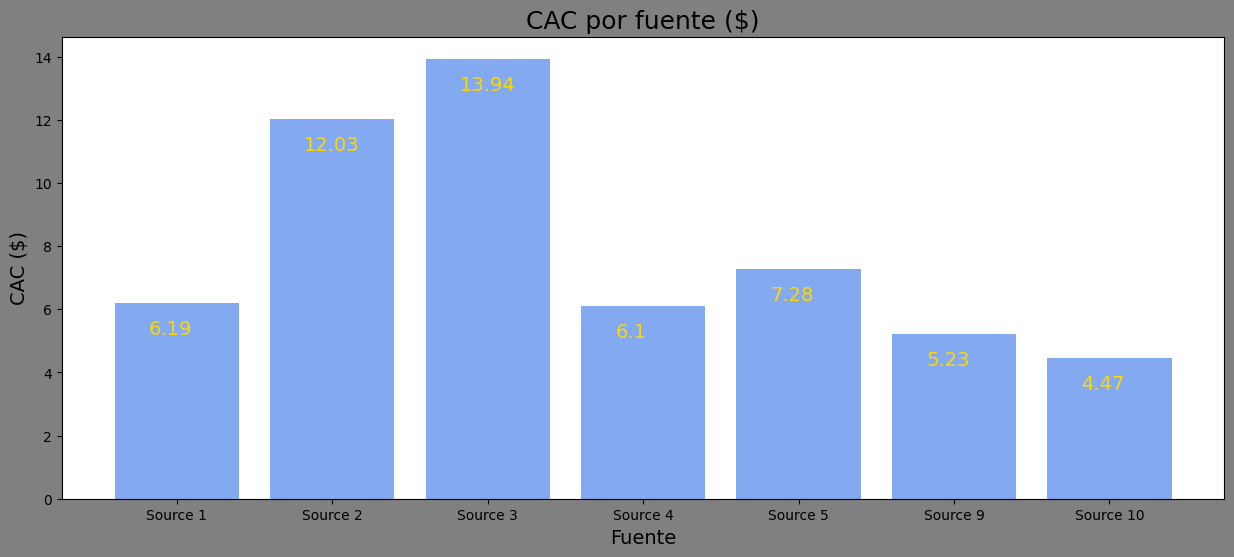

In [235]:
n = len(costs_source["cac"])
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, costs_source["cac"], align="center", alpha=0.8, color="cornflowerblue")

fig.patch.set_facecolor("grey")
plt.xlabel("Fuente", fontsize=14)
plt.ylabel("CAC ($)", fontsize=14)
plt.title("CAC por fuente ($)", fontsize=18)
plt.xticks(ind, costs_source["label"])
for idx, i in enumerate(ax.patches):
    ax.text(
        i.get_x() + 0.22,
        i.get_height() - 1,
        float(int(costs_source["cac"][idx] * 100) / 100),
        fontsize=14,
        color="gold",
    )
plt.show()

Conclusión:

Como podemos ver, las Fuentes 2 y 3 tienen los costos más altos por adquisición de clientes. Y si para la Fuente 2 esto está de alguna manera justificado por el hecho de que el LTV es lo suficientemente grande, entonces para la Fuente 3 el LTV es muy pequeño y el costo de atraer a un nuevo cliente es muy alto.

- **Por cohorte**

In [236]:

costs["dt"] = pd.to_datetime(costs["dt"])

# Encontrando el primer día del mes
costs["first_day_of_month_first_session"] = costs["dt"] - pd.to_timedelta(
    costs["dt"].dt.day - 1, unit="d"
)

# Agrupando los costos por el primer día del mes
costs_month = costs.groupby("first_day_of_month_first_session", as_index=False).agg(
    {"costs": "sum"}
)

# Revisamos los resultados
print(costs_month.head())

  first_day_of_month_first_session     costs
0                       2017-06-01  18015.00
1                       2017-07-01  18240.59
2                       2017-08-01  14790.54
3                       2017-09-01  24368.91
4                       2017-10-01  36322.88


In [237]:
costs_month = costs_month.merge(cohorts_ltv_0, on="first_day_of_month_first_session")

# Calculando CSC por cohorte
costs_month["cac"] = costs_month["costs"] / costs_month["count_orders_all"]
costs_month["first_month_str"] = costs_month[
    "first_day_of_month_first_session"
].dt.strftime("%m.%Y")

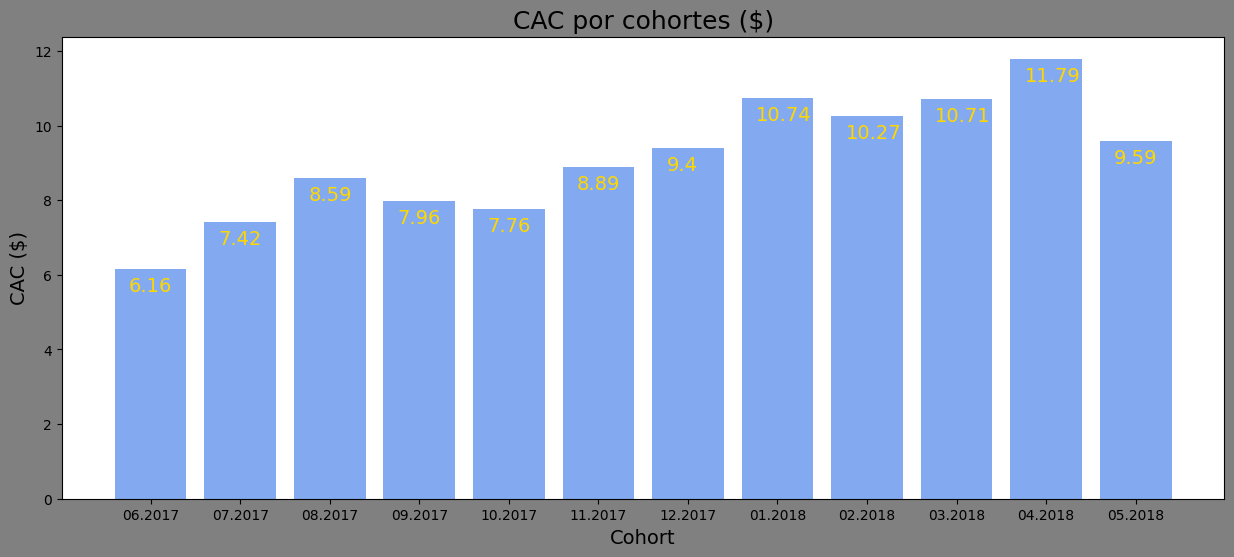

In [238]:
n = len(costs_month["cac"])
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, costs_month["cac"], align="center", alpha=0.8, color="cornflowerblue")

fig.patch.set_facecolor("grey")
plt.xlabel("Cohort", fontsize=14)
plt.ylabel("CAC ($)", fontsize=14)
plt.title("CAC por cohortes ($)", fontsize=18)
plt.xticks(ind, costs_month["first_month_str"])
for idx, i in enumerate(ax.patches):
    ax.text(
        i.get_x() + 0.16,
        i.get_height() - 0.6,
        float(int(costs_month["cac"][idx] * 100) / 100),
        fontsize=14,
        color="gold",
    )
plt.show()

Conclusión:

Como podemos ver, los costos aumentan con cada cohorte. Sabemos que algunos clientes realizan su primera compra más de 30 días después de su primera visita. Por lo tanto, los costos en los cohortes 04.2018 y 05.2018 disminuirán.

- **CALCULANDO EL ROI**

In [239]:
# Ingresos de clientes de cada cohorte.
cohorts_revenue = orders_all.groupby(
    "first_day_of_month_first_session", as_index=False
).agg({"revenue": "sum"})

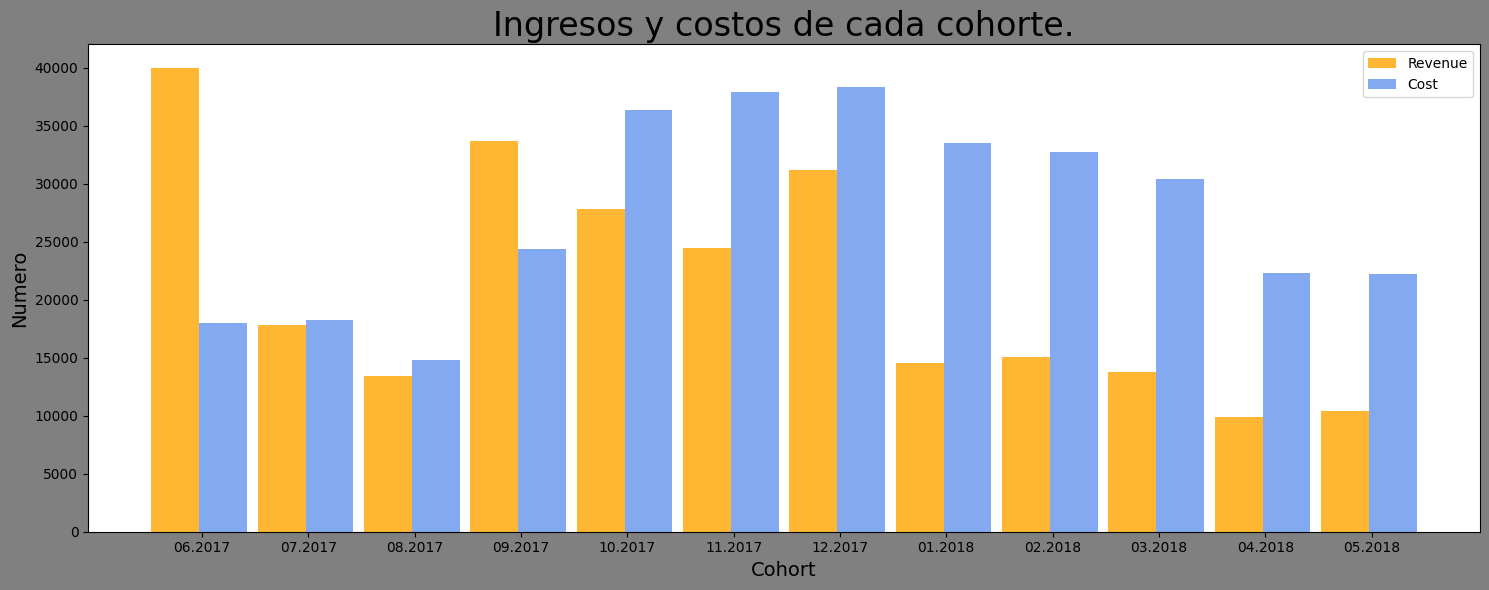

In [240]:
# oNuevo gráfico con dos columnas por cohortes/ingresos + costo
all_cohorts_dict = list(costs_month["first_month_str"].tolist())
n_groups = len(all_cohorts_dict)

# create plot
fig, ax = plt.subplots(figsize=(15, 6))
fig.patch.set_facecolor("grey")
index = np.arange(n_groups)
bar_width = 0.45
opacity = 0.8
rects1 = plt.bar(
    index,
    cohorts_revenue["revenue"],
    bar_width,
    alpha=opacity,
    color="orange",
    label="Revenue",
)

rects2 = plt.bar(
    index + bar_width,
    costs_month["costs"],
    bar_width,
    alpha=opacity,
    color="cornflowerblue",
    label="Cost",
)

plt.xlabel("Cohort", fontsize=14)
plt.ylabel("Numero", fontsize=14)
plt.title("Ingresos y costos de cada cohorte.", fontsize=24)

plt.xticks(index + bar_width - 0.2, all_cohorts_dict)
plt.legend()

plt.tight_layout()
plt.show()

Conclusión:

Como podemos ver en el histograma, en solo 2 cohortes, los ingresos son mayores que los costos. Esto indica que es necesario buscar áreas problemáticas y hacer ajustes.

- **CALCULANDO EL ROMI**

In [241]:
cohorts_romi = cohorts_ltv.merge(
    costs_month[["first_day_of_month_first_session", "costs"]],
    on="first_day_of_month_first_session",
)
cohorts_romi["romi"] = cohorts_romi["revenue_all"] / cohorts_romi["costs"]

In [242]:
# Creando tabla para usarla en gráfico
cohorts_romi_pivot_table = cohorts_romi.pivot_table(
    index="first_day_of_month_first_session_str",
    columns="cohort_lifetime",
    values="romi",
    aggfunc="sum",
)

Text(0.5, 58.7222222222222, 'Cohort Lifetime')

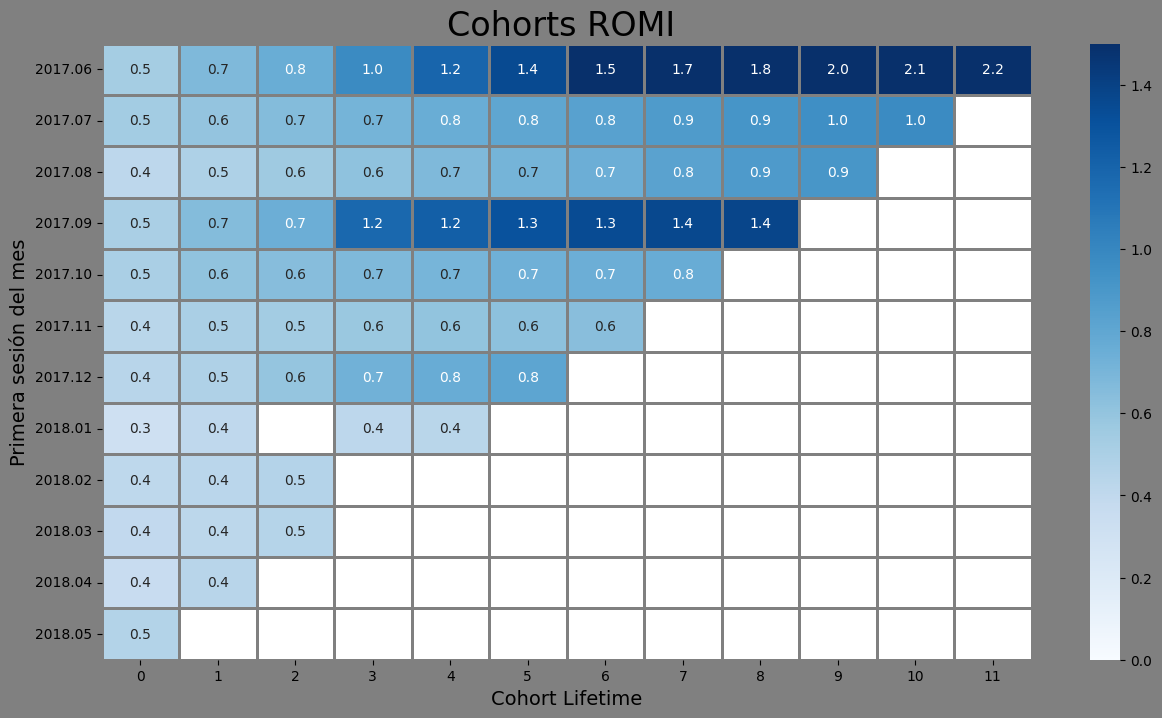

In [243]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor("grey")
plt.title("Cohorts ROMI ", fontsize=24)

sns.heatmap(
    cohorts_romi_pivot_table,
    annot=True,
    fmt=".1f",
    linewidths=1,
    linecolor="grey",
    vmin=0,
    vmax=1.5,
    cmap="Blues",
)
ax.set_ylabel("Primera sesión del mes", fontsize=14)
ax.set_xlabel("Cohort Lifetime", fontsize=14)

Conclusión:

Como se puede observar en el gráfico, la situación de rentabilidad es muy mala. La inversión realizada en la promoción no se recupera. Solo en tres cohortes (1, 2 y 4), los ingresos superaron los costos. Se puede suponer que si los costos no se recuperan con el tiempo, entonces el modelo de negocio actual no puede considerarse exitoso. Necesitamos hacer ajustes urgentemente. Además, no podemos asumir en qué mes la cohorte recuperará los fondos invertidos en la atracción de un cliente, ya que solo 3 cohortes recuperaron sus inversiones, y 2 de ellas tienen una dinámica claramente anormal. Es difícil hacer un pronóstico preciso basado en los datos disponibles.

- **ROMI respecto a la fuente**

In [244]:
source_romi = orders_all[
    [
        "revenue",
        "first_session",
        "source_id",
        "actual_date",
        "first_day_of_month_first_session",
        "first_day_of_month_actual_order",
    ]
]

In [245]:

orders_all["days_diff"] = (
    orders_all["first_day_of_month_actual_order"]
    - orders_all["first_day_of_month_first_session"]
).dt.days
orders_all["cohort_lifetime"] = (orders_all["days_diff"] / 30.44).round().astype(int)

print(
    orders_all[
        [
            "first_day_of_month_actual_order",
            "first_day_of_month_first_session",
            "days_diff",
            "cohort_lifetime",
        ]
    ].head()
)

  first_day_of_month_actual_order first_day_of_month_first_session  days_diff  \
0                      2017-06-01                       2017-06-01          0   
1                      2017-06-01                       2017-06-01          0   
2                      2017-06-01                       2017-06-01          0   
3                      2017-06-01                       2017-06-01          0   
4                      2017-06-01                       2017-06-01          0   

   cohort_lifetime  
0                0  
1                0  
2                0  
3                0  
4                0  


In [246]:
source_romi = orders_all[
    ["source_id", "cohort_lifetime", "revenue"]
] 

print(source_romi.head())

   source_id  cohort_lifetime  revenue
0          1                0    17.00
1          2                0     0.55
2          2                0     0.37
3          2                0     0.55
4          3                0     0.37


In [247]:
#  `source_id` y `cohort_lifetime` para calcular el ingreso total
source_lifetime = source_romi.groupby(
    ["source_id", "cohort_lifetime"], as_index=False
).agg({"revenue": "sum"})

# Verifica los resultados
print(source_lifetime.head())

   source_id  cohort_lifetime   revenue
0          1                0  17261.90
1          1                1   3123.30
2          1                2   1911.45
3          1                3   2836.84
4          1                4   1731.94


In [248]:
source_lifetime = (
    source_romi.groupby(["source_id", "cohort_lifetime"], as_index=False)
    .agg({"revenue": "sum"})
    .reset_index()
)

In [249]:
source_cumsum = (
    source_lifetime.groupby("source_id").agg({"revenue": "cumsum"}).reset_index()
)
source_cumsum = source_cumsum.rename(columns={"revenue": "revenue_source"})

In [250]:
source_lifetime = source_lifetime.merge(source_cumsum, on="index")
source_cost = costs.groupby("source_id", as_index=False).agg({"costs": "sum"})
source_lifetime = source_lifetime.merge(source_cost, on="source_id")
source_lifetime["romi"] = source_lifetime["revenue_source"] / source_lifetime["costs"]
source_lifetime["label"] = source_lifetime.apply(create_label, axis=1)

In [251]:
source_lifetime_pivot_table = source_lifetime.pivot_table(
    index="label", columns="cohort_lifetime", values="romi", aggfunc="sum"
)

Text(0.5, 58.7222222222222, 'Cohort Lifetime')

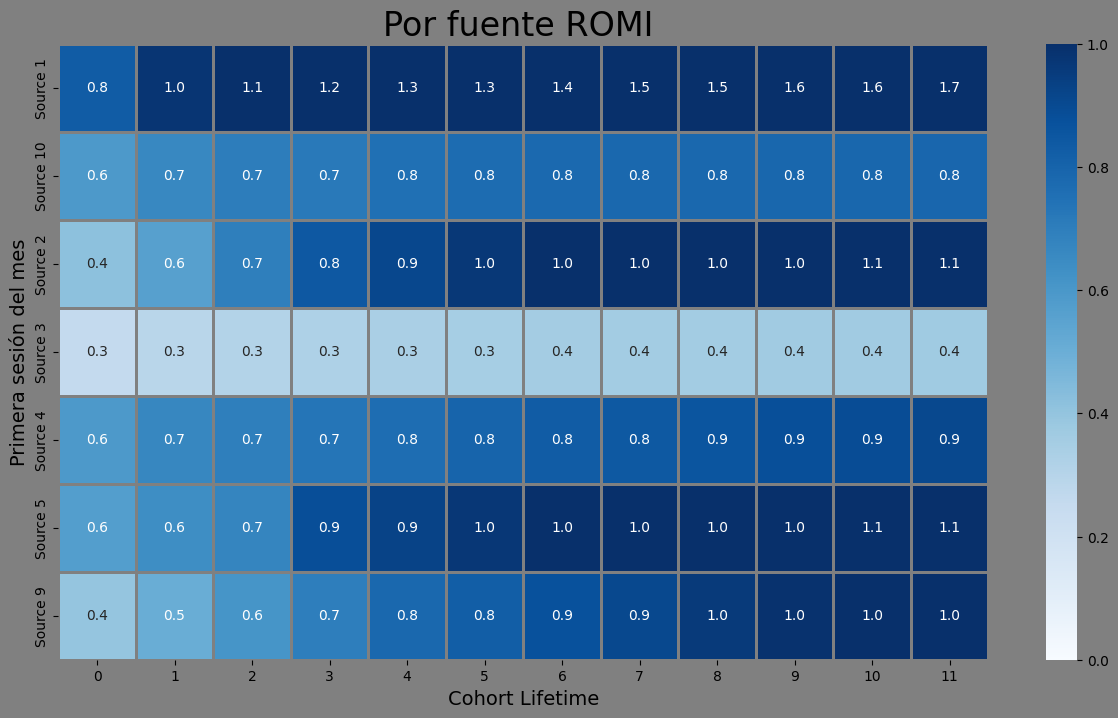

In [252]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor("grey")
plt.title("Por fuente ROMI ", fontsize=24)

sns.heatmap(
    source_lifetime_pivot_table,
    annot=True,
    fmt=".1f",
    linewidths=1,
    linecolor="grey",
    vmin=0,
    vmax=1,
    cmap="Blues",
)
ax.set_ylabel("Primera sesión del mes", fontsize=14)
ax.set_xlabel("Cohort Lifetime", fontsize=14)

Conclusión:

En la parte anterior, descubrimos que casi todas las cohortes no generan retorno de inversión en la atracción de clientes. En esta parte, aprendimos que las inversiones en Fuentes 10, 3 y 4 deben detenerse urgentemente, ya que el costo de atracción es mayor que la ganancia proveniente de los clientes. La Fuente 9 está al borde de recuperación, y si no encontramos cómo aumentar el LTV o reducir el CAC, entonces esta fuente también debería ser abandonada. La más atractiva es la Fuente 1 y, si hay oportunidad de aumentar el número de clientes de ella, se debe hacer.

La Fuente 3 gasta la mayor cantidad de dinero en la atracción de clientes, pero estas inversiones no generan ganancias. La imagen general no parece ser financieramente exitosa y la mayoría de las cohortes no son rentables. Sin embargo, si no fuera por la gran inversión en la Fuente 3, la mayoría de las cohortes serían rentables. Simulamos la situación sin la Fuente 3.

## Paso 3 : Conclusiones



1. **Source 1 (№ 1):**
   - ROMI (Return on Marketing Investment): 1.7
   - LTV (Lifetime Value): 10.34 USD
   - CAC (Customer Acquisition Cost): 6.19 USD
   - Orders (%): 11.52
   - Costs (%): 6.33
   - Revenue (%): 13.81
   - Conversion, days: 9

   Esta fuente se destaca como la más prometedora, con un excelente ROMI y una conversión rápida en 9 días. Sin embargo, se debe trabajar en aumentar el número de clientes de este recurso para maximizar su potencial.

2. **Source 2 (№ 2):**
   - ROMI: 1.1
   - LTV: 12.74 USD
   - CAC: 12.03 USD
   - Orders (%): 12.51
   - Costs (%): 13.01
   - Revenue (%): 17.99
   - Conversion, days: 20

   Esta fuente muestra indicadores sólidos, pero se necesita trabajar en aumentar el LTV y reducir el CAC para mejorar su rentabilidad.

3. **Source 3 (№ 3):**
   - ROMI: 0.4
   - LTV: 5.12 USD
   - CAC: 13.94 USD
   - Orders (%): 25.42
   - Costs (%): 42.94
   - Revenue (%): 20.61
   - Conversion, days: 18

   Esta fuente tiene los peores indicadores y se recomienda detener la inversión de inmediato. Se debe investigar la razón detrás de los altos costos y las ventas bajas.

4. **Source 4 (№ 4):**
   - ROMI: 0.9
   - LTV: 5.53 USD
   - CAC: 6.1 USD
   - Orders (%): 24.82
   - Costs (%): 18.56
   - Revenue (%): 21.97
   - Conversion, days: 16

   Esta fuente es poco rentable y se necesita trabajar en mejorar el LTV y reducir el CAC. De no lograrlo, se debe considerar detener la inversión en este origen.

5. **Source 5 (№ 5):**
   - ROMI: 1.1
   - LTV: 7.65 USD
   - CAC: 7.28 USD
   - Orders (%): 19.48
   - Costs (%): 15.73
   - Revenue (%): 21.60
   - Conversion, days: 13

   Esta fuente tiene buenos indicadores y se recomienda trabajar en mejorar el LTV y reducir el CAC para optimizar su rendimiento.

6. **Source 9 (№ 9):**
   - ROMI: 1.0
   - LTV: 5.25 USD
   - CAC: 5.23 USD
   - Orders (%): 3.15
   - Costs (%): 1.68
   - Revenue (%): 2.20
   - Conversion, days: 45

   Esta fuente está cerca del punto de equilibrio pero tiene una baja participación en pedidos. Se necesita mejorar el LTV y reducir el CAC para hacerla más atractiva.

7. **Source 10 (№ 10):**
   - ROMI: 0.8
   - LTV: 3.53 USD
   - CAC: 4.47 USD
   - Orders (%): 3.09
   - Costs (%): 1.77
   - Revenue (%): 1.82
   - Conversion, days: 12

   Esta fuente es poco rentable y tiene una baja participación en pedidos. Se recomienda mejorar el LTV y reducir el CAC, considerando detener la inversión si no se logra.

Las fuentes se evalúan en función de su ROMI, LTV, CAC, participación en pedidos, costos y conversión. Es crucial priorizar el trabajo en aquellas fuentes con mejores indicadores y realizar ajustes estratégicos en las fuentes menos rentables para mejorar su rendimiento o considerar detener la inversión si no muestran mejoras significativas, pero en este caso, recomendaría las siguientes fuentes/plataformas:

1. Source 1 
2. Source 2 
3. Source 5 

Fundamento mi selección en las métricas clave de ROMI (Return on Marketing Investment), LTV (Lifetime Value), CAC (Customer Acquisition Cost), participación en pedidos, costos y conversión.

Me enfoqué en estas métricas porque proporcionan una visión integral del rendimiento de cada fuente/plataforma. Un ROMI alto indica eficiencia en la inversión en marketing, mientras que un LTV alto en relación con el CAC indica una adquisición rentable de clientes. Además, la participación en pedidos, los costos y la conversión son indicadores importantes de la efectividad y rentabilidad de cada fuente.

Después de encontrar los valores métricos, saqué las siguientes conclusiones:
- Source 1 es la más prometedora con excelentes indicadores de ROMI, LTV y Conversion, lo que sugiere un alto potencial de rentabilidad.
- Source 2 muestra indicadores sólidos, pero necesita trabajar en aumentar el LTV y reducir el CAC para mejorar su rendimiento.
- Source 5 también tiene buenos indicadores y se recomienda mejorar el LTV y reducir el CAC para optimizar su rendimiento.